# Dev / Library

In [238]:
!pip install coclust
!pip install tqdm

    100% |████████████████████████████████| 51kB 502kB/s 


In [239]:
from tqdm import tqdm_notebook as tqdm

In [2]:
import numpy as np

In [3]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import random

In [4]:
def save_fig(name):
    plt.savefig(f'./figures/pdf/{name}.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f'./figures/png/{name}.png', format='png', bbox_inches='tight')

## Import data from spoon.

In [5]:
import json
def open_json(file_path):
    datastore = {}
    with open(file_path, 'r') as f:
        datastore = json.load(f)
    return datastore

A fonction to get the name of a library according to its definition and the depth.

> 'java.util.ArrayList', depth=2 -> 'java.util'



In [6]:
def import_to_name(library_import, depth):
    return '.'.join(library_import.split('.')[:depth])

Define the mapping of imports to an ids.

In [7]:
def define_mapping(libraries_set, depth): # TODO : Option to keep tree structure
    A = set(sorted([import_to_name(library_import, depth) for library_import in libraries_set]) + ['UNK'])
    length = len(A)
    map_dict = dict(zip(A, range(length)))
    def mapping(import_value):
        name = import_to_name(import_value, depth)
        if name not in A:
            name = 'UNK'
        return map_dict[name]
    return mapping, A, length

In [8]:
# 2 more or less equal to the library level 
data = open_json('spoon_commits.json')
libraries_set = data['libraries_set']
commit_info = data['commit_info']
library_depth = 2
mapping, mapping_elemnts, mapping_size = define_mapping(libraries_set, library_depth)

Some basic vector operators

In [9]:
def v_sum(*v):
    return tuple([sum(e) for e in zip(*v)])

def z_k(n, *Ks):
    z_k = [0] * n
    for i in Ks:
        z_k[i] = 1
    return tuple(z_k)

Count for every commits the number of time a library was imported in all modified files.

In [10]:
import pandas as pd
data = []

duplicate_entries = (
    ('Martin Monperrus', 'martin'),
    ('Thomas Durieux', 'tdurieux'),
    ('Nicolas Petitprez', 'petitpre'),
    ('Gérard Paligot', 'GerardPaligot'),
    ('Gérard Paligot', 'Gerard Paligot'),
    ('Gérard Paligot', 'Gerard'),
    ('Roman Leventov', 'leventov'),
    ('Benjamin DANGLOT', 'danglotb'),
    ('Tomasz Zieliński', 'Tomasz Zielinski'),
    ('martinezmatias', 'matiasmartinez'),
    ('Marcel Steinbec', 'Marcel'),
    ('Marcel Steinbec', 'Marcel Steinbeck'),
    ('Egor Bredikhin', 'Egor18')
)

duplicate_entries = dict([ (b,a) for (a,b) in duplicate_entries])
author_emails = {}

for sha, commit in list(commit_info.items()):
    author_name = commit['author']['name']
    if author_name in duplicate_entries:
        commit['author']['name'] = duplicate_entries[author_name]
    if commit['author']['email'] not in author_emails:
        author_emails[commit['author']['email']] = set()
    author_emails[commit['author']['email']] = author_emails[commit['author']['email']] | set([author_name])

for sha, commit in list(commit_info.items()):
    libraries = set()
    c = z_k(mapping_size)
    for file, file_info in commit['files_info'].items():
        file_libraries = set([ mapping(lib) for lib in file_info['imports'] ])
        libraries = libraries | file_libraries
        c = v_sum(c, z_k(mapping_size, *file_libraries))
    if len(libraries) > 0:
        author_name = commit['author']['name']
        data.append( [sha, author_name] + list(c))
        #data.append( [sha, commit['author']['name']] + list(z_k(mapping_size, *libraries)))

df = pd.DataFrame(data=data, columns=['sha', 'author', *mapping_elemnts])

In [11]:
{ key:item for key, item in author_emails.items() if len(item)>1}

{'32983915+Egor18@users.noreply.github.com': {'Egor Bredikhin', 'Egor18'},
 'durieuxthomas@hotmail.com': {'Thomas Durieux', 'tdurieux'},
 'tomek.j2ee@gmail.com': {'Tomasz Zielinski', 'Tomasz Zieliński'},
 'github@retux.de': {'Marcel', 'Marcel Steinbeck'},
 'gerard.paligot@gmail.com': {'Gerard',
  'Gerard Paligot',
  'GerardPaligot',
  'Gérard Paligot'},
 'bdanglot@gmail.com': {'Benjamin DANGLOT', 'bdanglot', 'danglotb'},
 'leventov@ya.ru': {'Roman Leventov', 'leventov'}}

In [12]:
print(f'Total number of commit : {df.shape[0]}')
print(f'Made by {len(set(df.author))} unique contibutors')
print(f'Represented by {len(libraries_set)} imports')
print(f'mapped to {len(mapping_elemnts)} imports')

Total number of commit : 2344
Made by 56 unique contibutors
Represented by 2473 imports
mapped to 149 imports


Sum the commits by users.

**Then drop the contibutors who has modified 10 file or less. And the libraries imported less than once**

Finally sort the data in row and column by the number of modifications.

In [13]:
def group_duplicate_entry(df, *duplicate_entries):
    for entry1, entry2 in duplicate_entries:
        df.loc[entry1] = df.loc[entry1] + df.loc[entry2]
        df = df.drop(entry2)
    return df

agreg = df.groupby('author').sum()
agreg = agreg.loc[:,agreg.sum() > 1]
#agreg = agreg.loc[agreg.sum(axis=1) > 100]

#agreg = group_duplicate_entry(agreg, *duplicate_entries)

agreg_sorted = agreg.loc[agreg.sum(axis=1).sort_values(ascending=False).index]
agreg_sorted = agreg_sorted.loc[:,agreg_sorted.sum(axis=0).sort_values(ascending=False).index]

In [14]:
total_count = max(df.index)
f = {'index': ['mean', 'min', 'max', 'count']}
avg_contrib = pd.DataFrame(
    data=list(
        zip(
            df.loc[:,'author'],
            [ total_count - i for i in df.index])
        ),
    columns=['author', 'index']
).groupby('author').agg(f)
avg_contrib.head()

index                  
                        mean   min   max count
author                                        
Alcides Fonseca        880.4   752  1022     5
André Cruz            1793.0  1793  1793     1
Artur Bosch           1285.0  1199  1371     2
Ashutosh Kumar Verma  1922.0  1871  1984     6
Benjamin DANGLOT      1318.0  1055  2326    18

In [15]:
libraries_info = pd.DataFrame(data=[[0,0,0]] * len(mapping_elemnts), columns=['first', 'last', 'count'])
libraries_info.index = mapping_elemnts
for (index, row) in df.iloc[:,2:].iterrows():
    for lib, val in row.items():
        if val != 0:
            if libraries_info.loc[lib]['last'] == 0:
                libraries_info.loc[lib]['last'] = len(df) - index
            else:
                libraries_info.loc[lib]['first'] = len(df) - index
            libraries_info.loc[lib]['count'] += val

In [16]:
libraries_info['coef'] = np.exp(libraries_info.loc[:,'last'] / len(df) - 1) ** 3

In [17]:
libraries_info.head()

first  last  count      coef
spoon.decompiler    2152  2235      5  0.869789
spoon.template         1  2297    618  0.941620
org.elasticsearch   1374  1689      5  0.432440
javax.persistence      0  1218      1  0.236661
org.hamcrest        1375  2332    172  0.984759

In [18]:
#fig, ax = plt.subplots(figsize=(14, 25), dpi=80)

#for i, row in libraries_info.sort_values('last').iterrows():
#    color = 'r'
#    ax.hlines(i, xmin=row['first'], xmax=row['last'], color=color)

#plt.show()

## Distance between libraries

[]

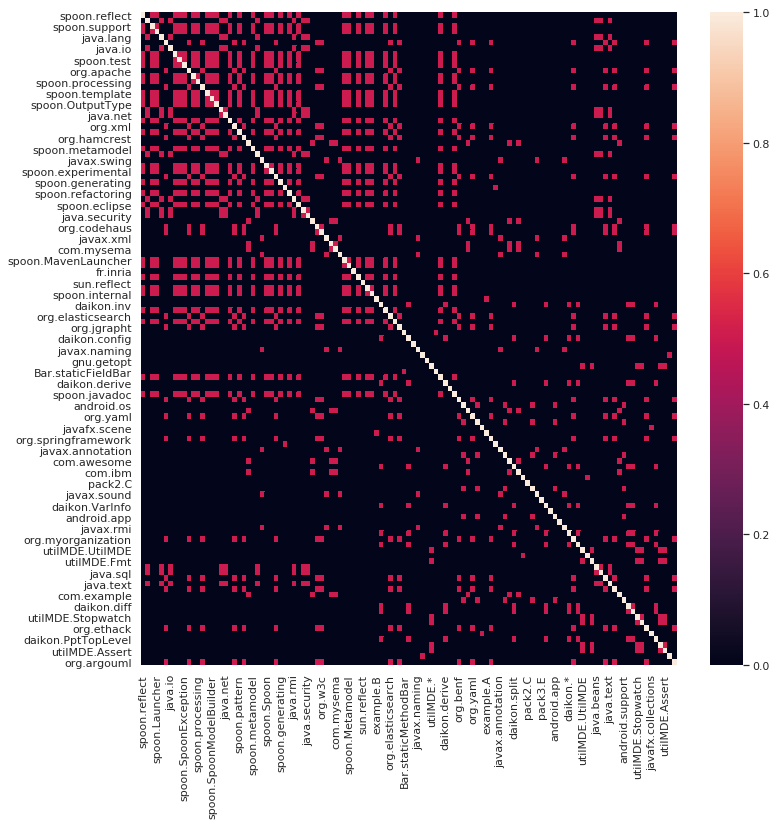

In [19]:
libraries = list(agreg_sorted.columns)
#libraries.sort()
librariy_trees = {}
def import_similarity(lib_A, lib_B):
    nodes_A = lib_A.split('.')
    nodes_B = lib_B.split('.')
    n = 0
    for node_A, node_B in zip(nodes_A, nodes_B):
        if node_A == node_B:
            n+=1
        else:
            break
    return n / library_depth

libraries_distance = pd.DataFrame(list(map(lambda x: list(map(lambda y: import_similarity(x,y), libraries)), libraries)), index=libraries, columns=libraries)
plt.figure(figsize=(12,12))
sns.heatmap(libraries_distance)
plt.plot()
#for library in libraries:
#    nodes = library.split('.')
#    tree = librariy_trees
#    for node in nodes:
#        if node not in tree:
#            tree[node] = {}
#        tree = tree[node]
#print(librariy_trees)

Laplacien normalisé ? 

## Analysis

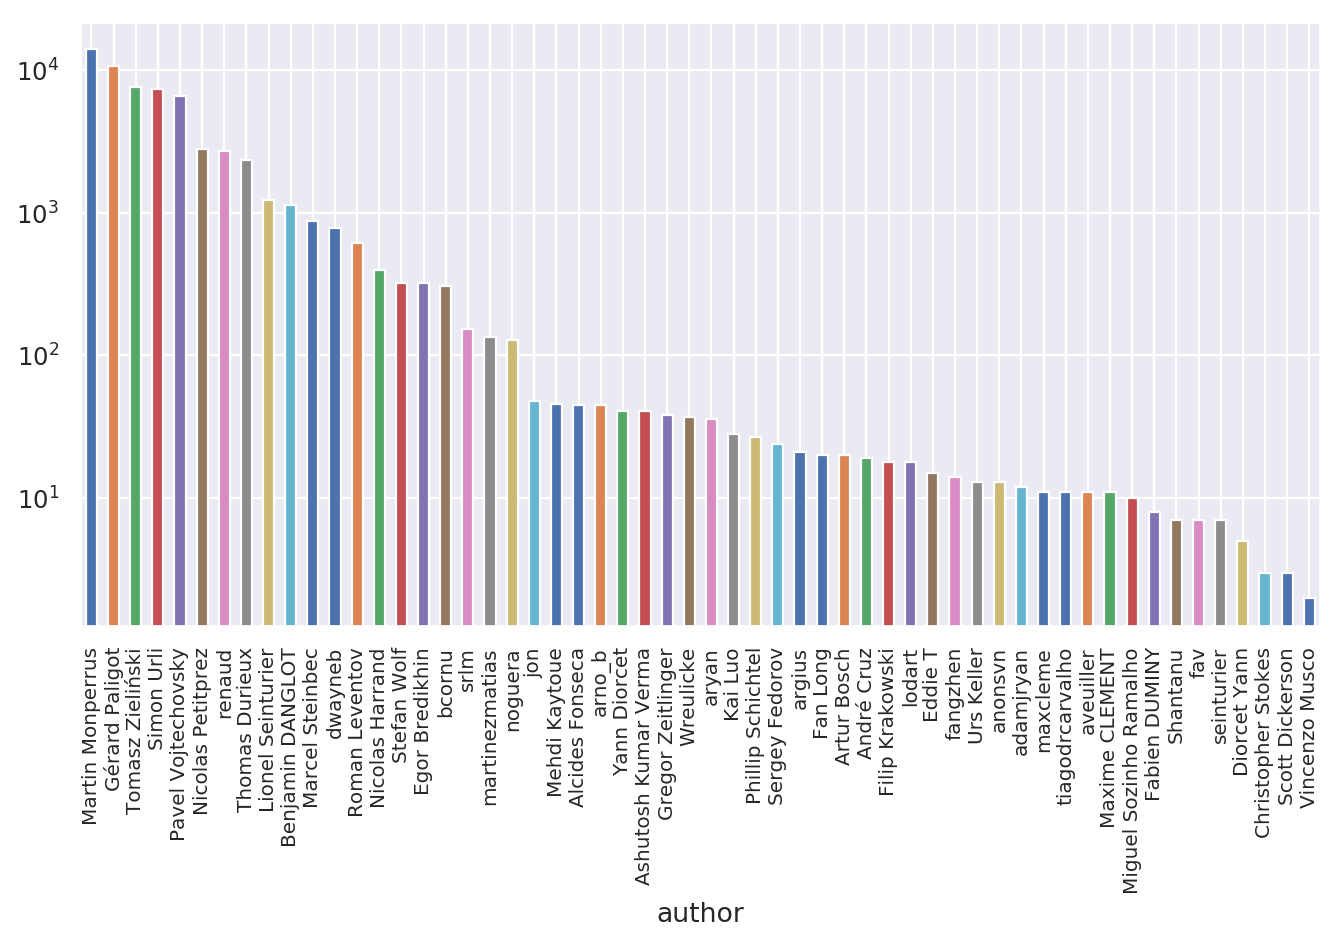

In [20]:
fig = plt.figure(figsize=(10, 5), dpi=160, facecolor='w', edgecolor='k')
number_of_contibs = agreg_sorted.sum(axis=1)
ax = number_of_contibs.plot.bar()
ax.set_yscale('log')
plt.xticks(range(len(list(number_of_contibs.index))), list(number_of_contibs.index), rotation=90, fontsize=9)
plt.show()

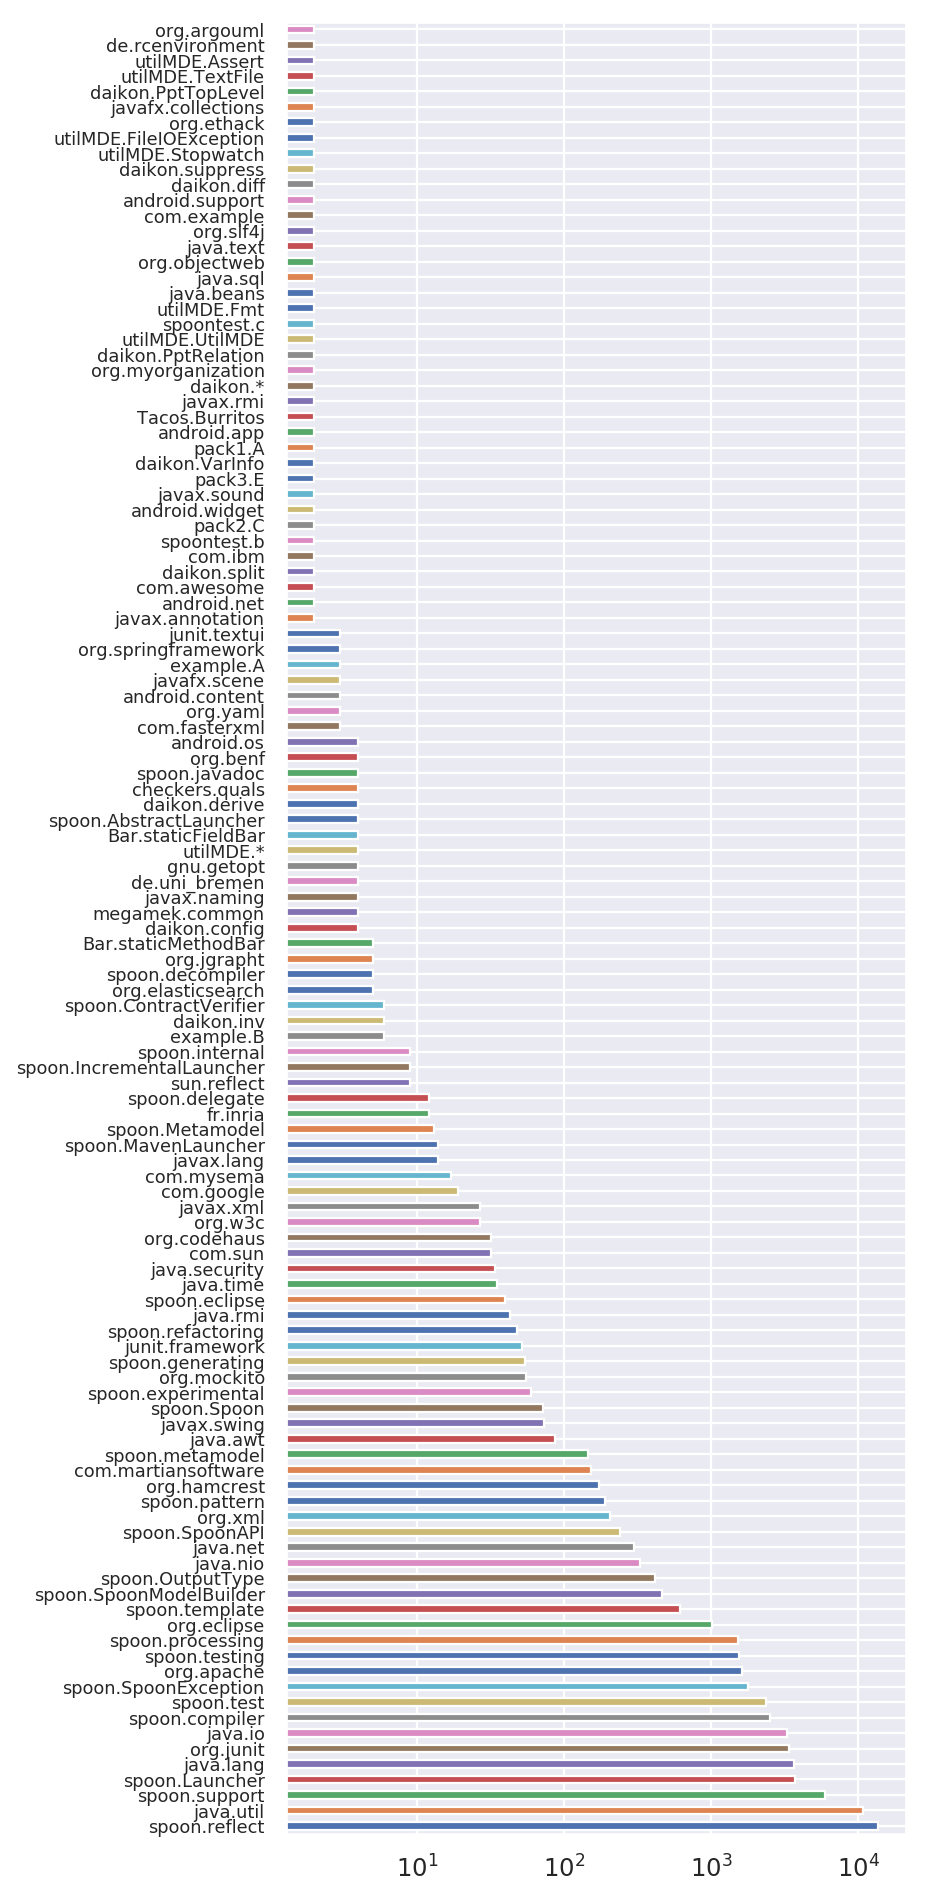

In [21]:
fig = plt.figure(figsize=(5, 15), dpi=160, facecolor='w', edgecolor='k')
number_of_imports = agreg_sorted.sum(axis=0)
ax = number_of_imports.plot.barh()
ax.set_xscale('log')
plt.yticks(range(len(list(number_of_imports.index))), list(number_of_imports.index), fontsize=8)
plt.show()

In [22]:
def plot_matrix(df, title, xlabel = '', ylabel='', log_scale=False, figsize=(18, 8)):
    fig = plt.figure(figsize=figsize, dpi=160, facecolor='w', edgecolor='k')
    if log_scale:
        sns.heatmap(np.log10(df.add(1)))
    else:
        sns.heatmap(df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.array(range(len(list(df.columns)))) + 0.5, list(df.columns), rotation=90, fontsize=9)
    plt.yticks(np.array(range(len(list(df.index)))) + 0.5, list(df.index), fontsize=9)
    plt.title(title, fontsize=24)
    #plt.ylabel('some numbers')
    #plt.show()

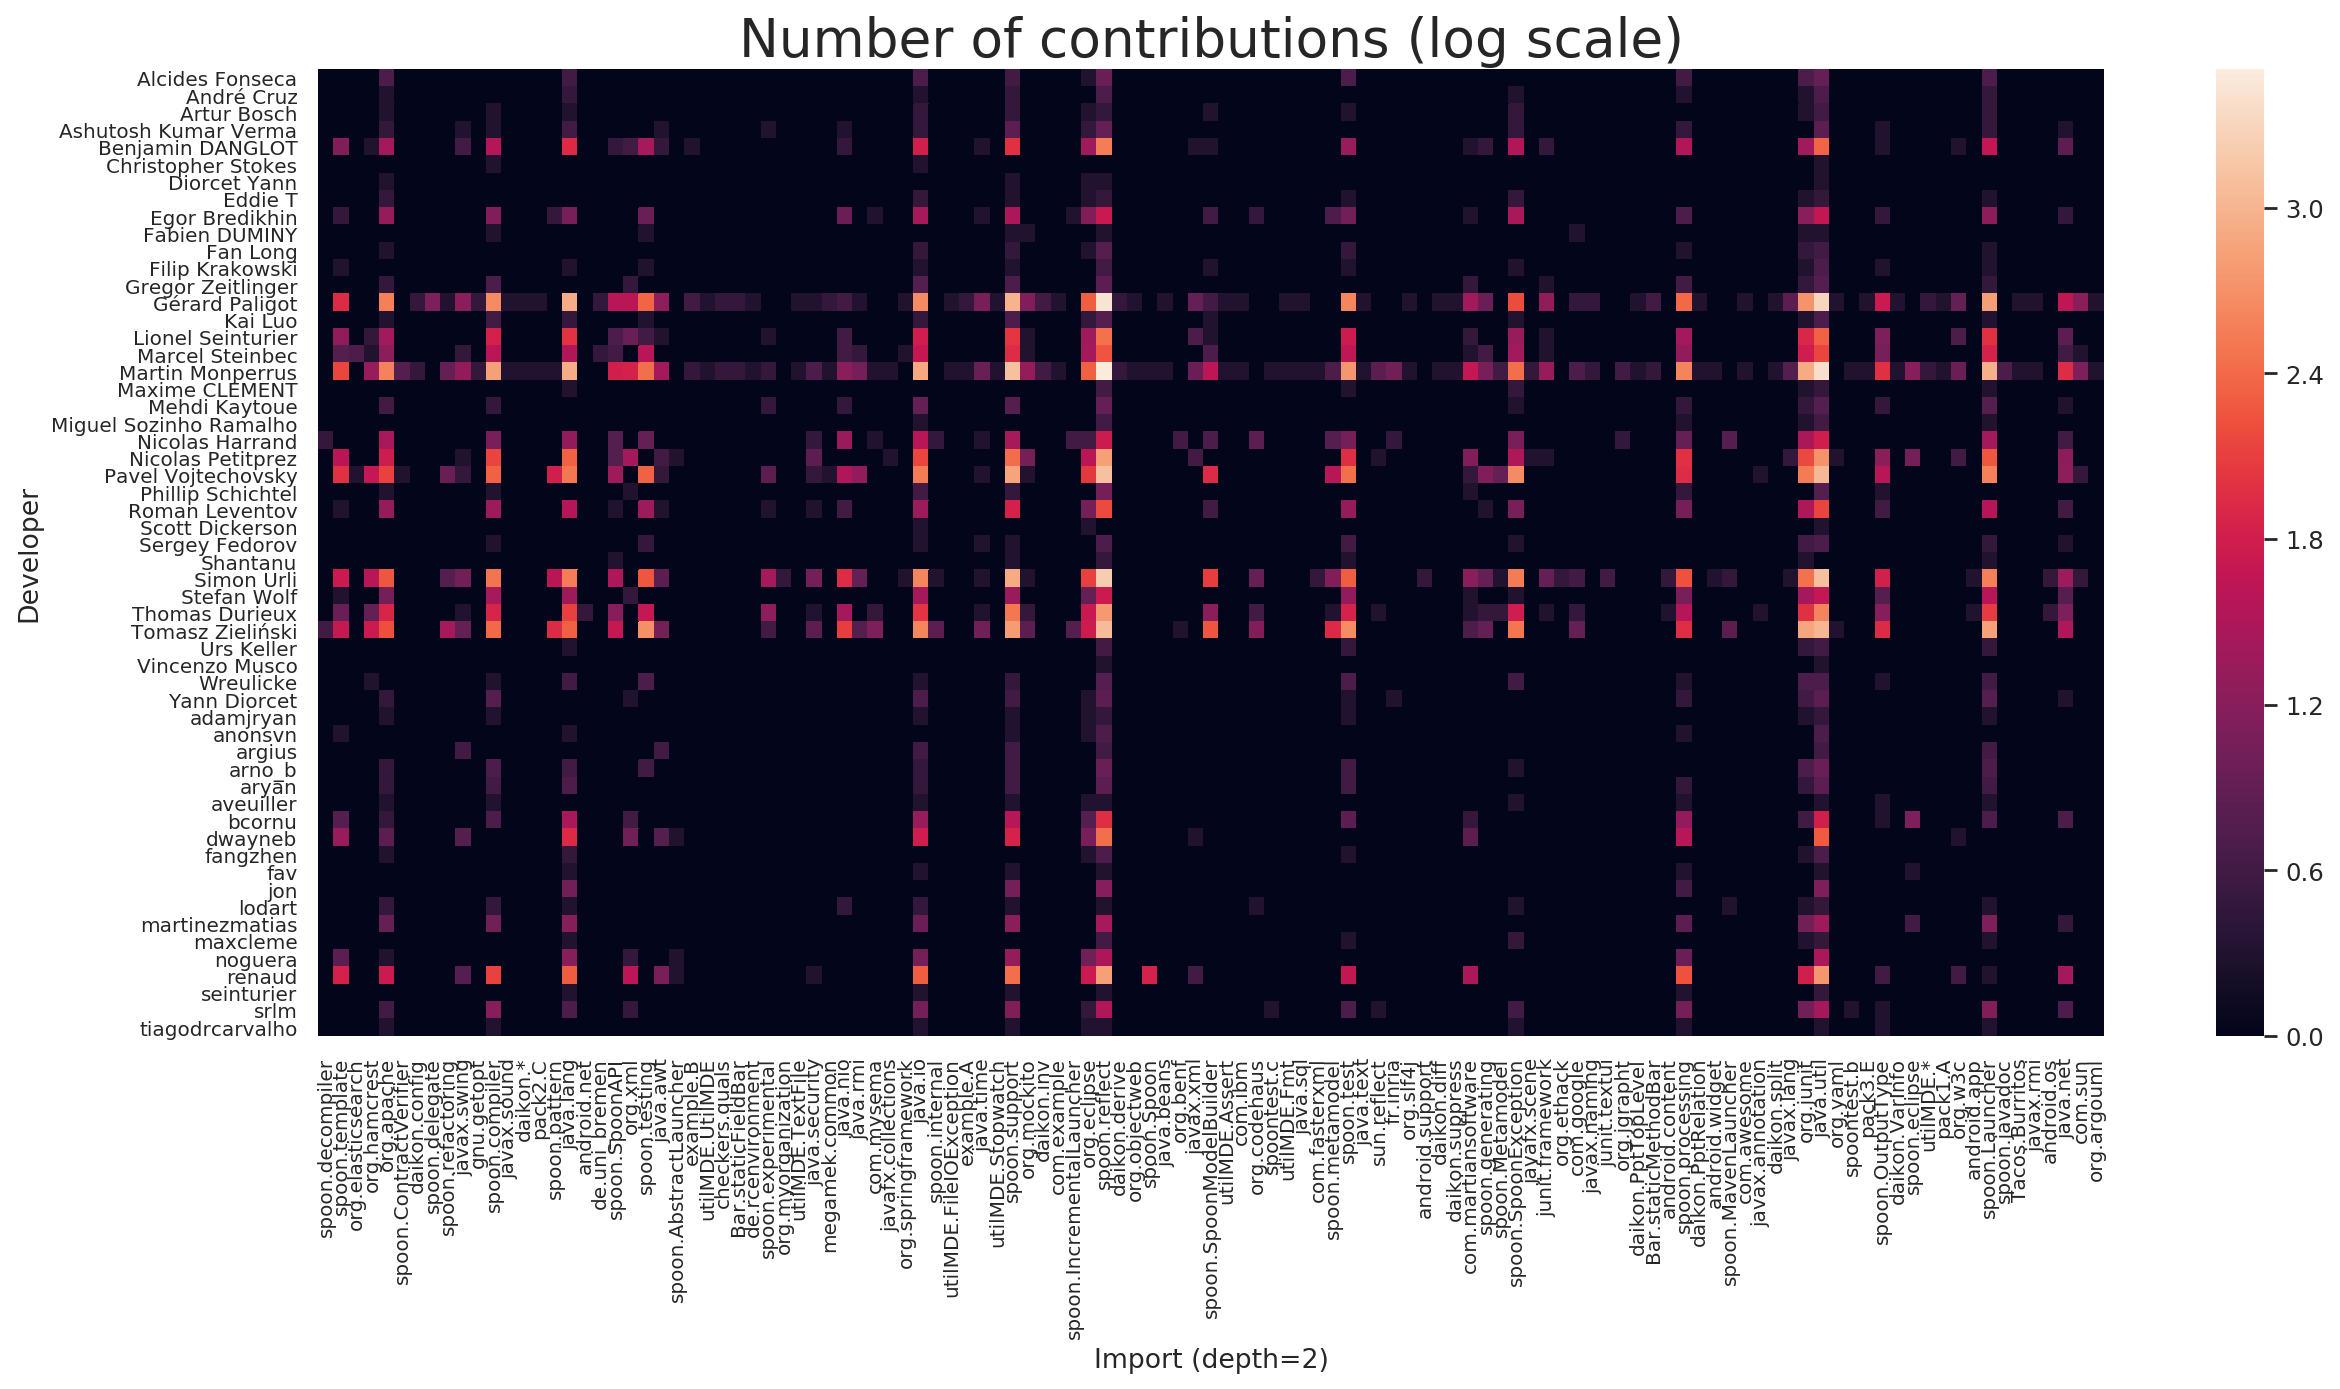

In [23]:
plot_matrix(agreg, 'Number of contributions (log scale)', xlabel='Import (depth=2)', ylabel='Developer', log_scale=True)
save_fig('author_lib_random')
plt.show()

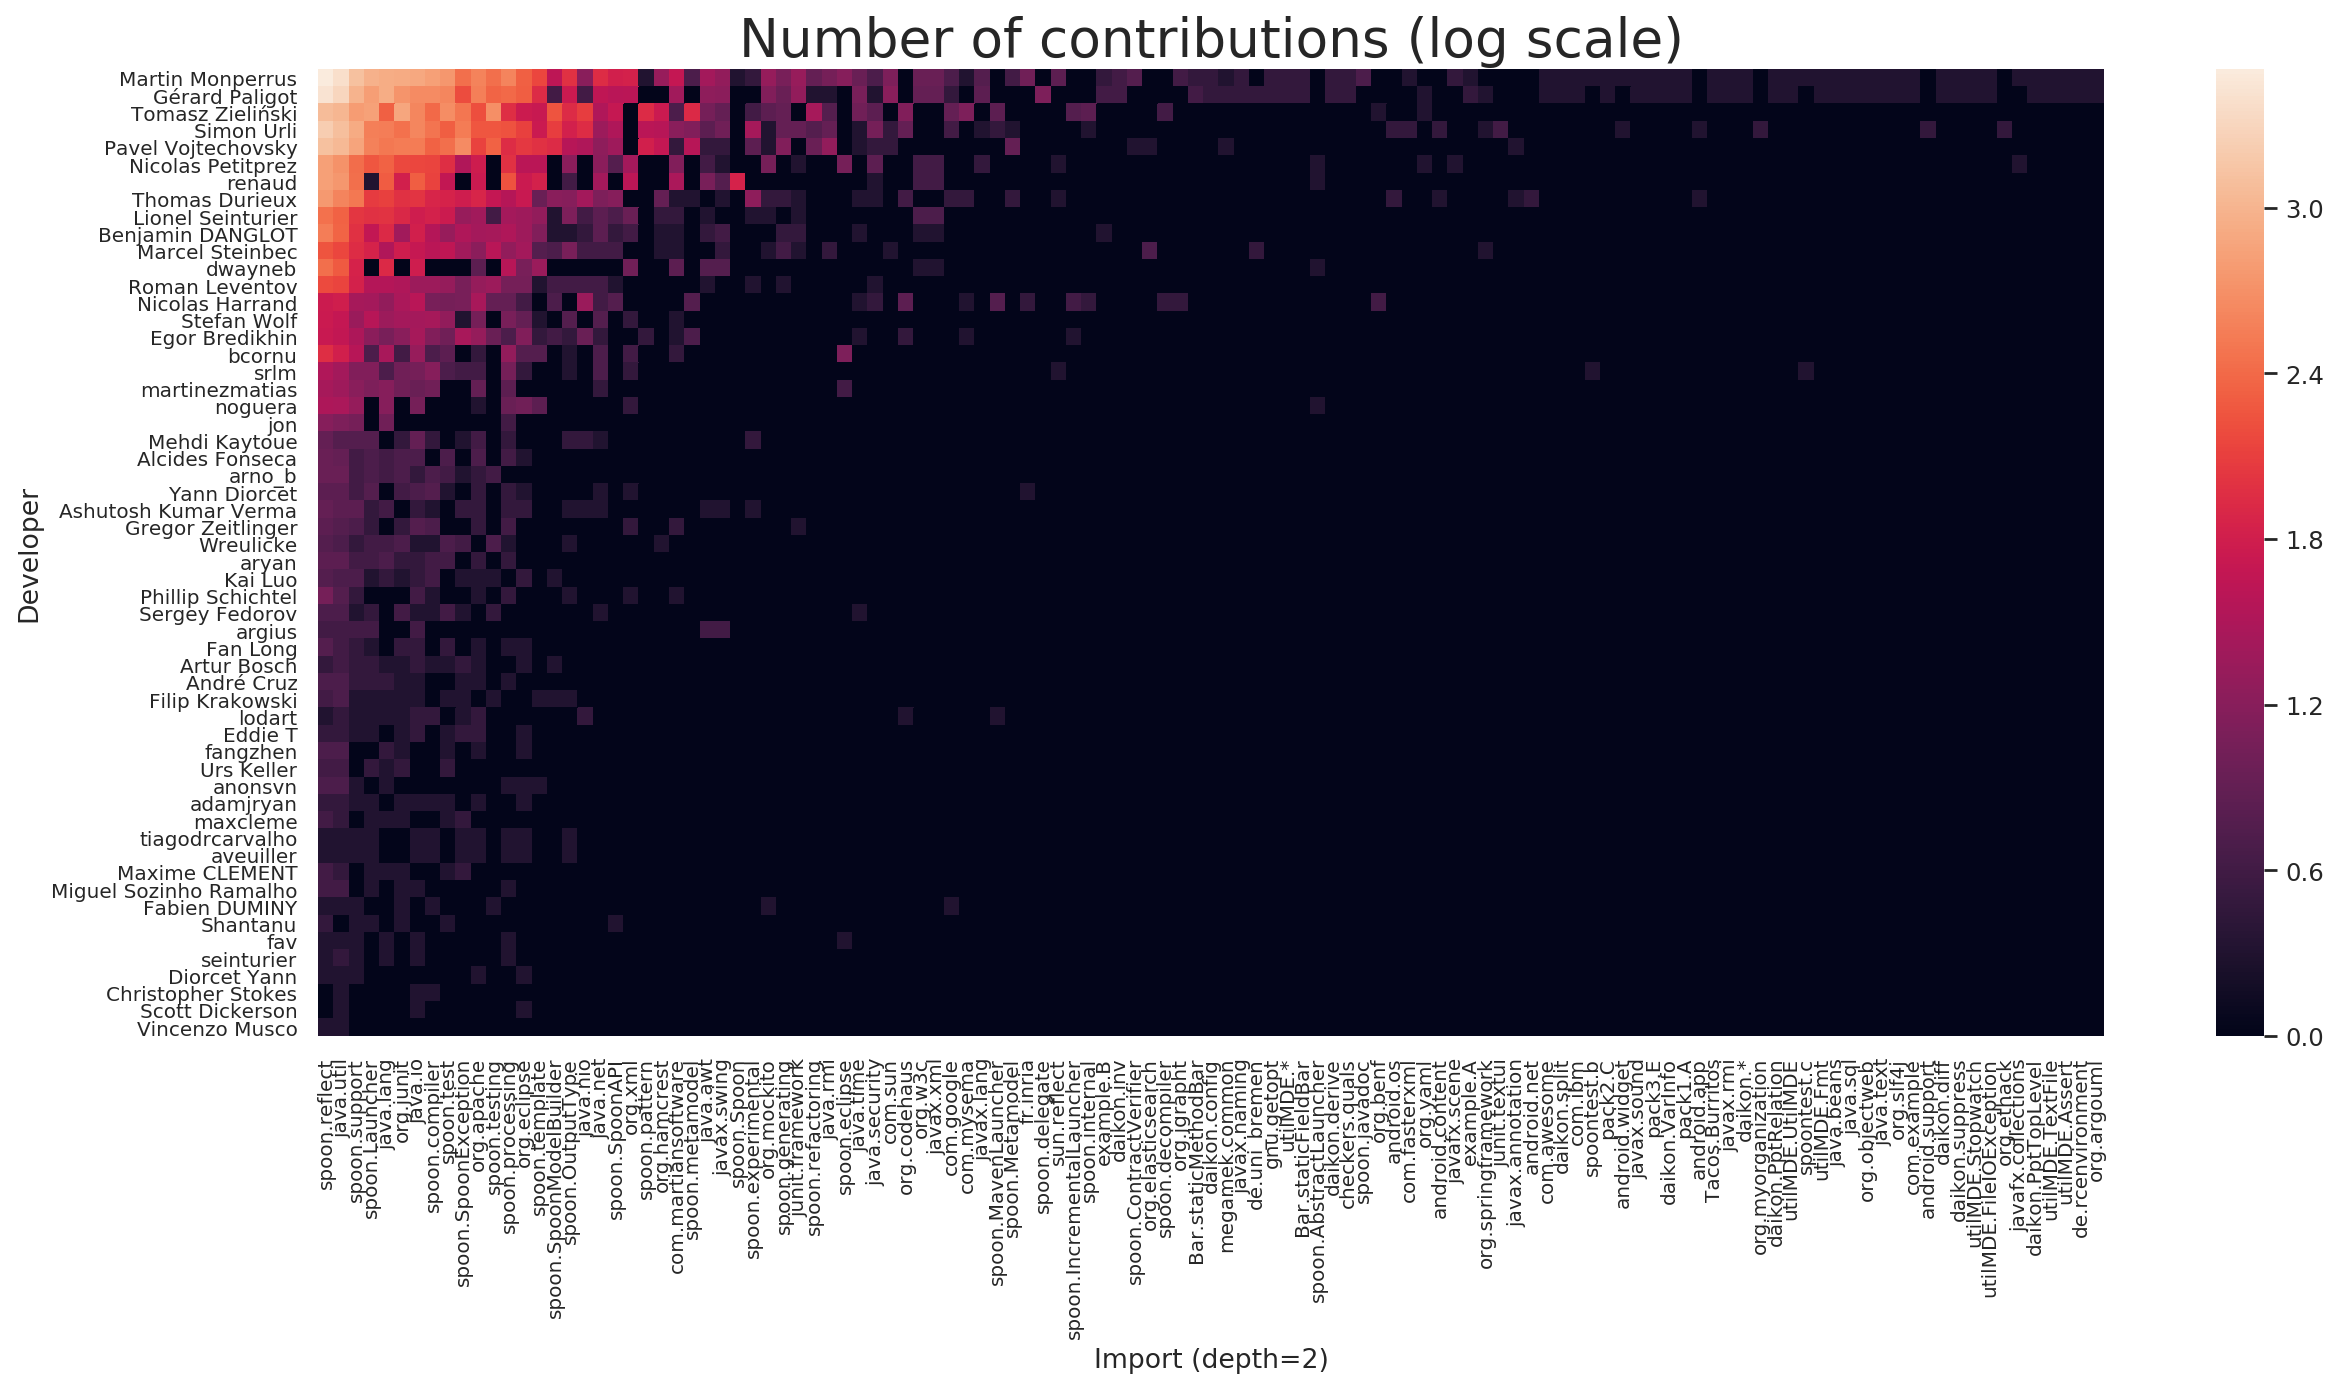

In [24]:
plot_matrix(agreg_sorted, 'Number of contributions (log scale)', xlabel='Import (depth=2)', ylabel='Developer', log_scale=True)
save_fig('author_lib_ordered')
plt.show()

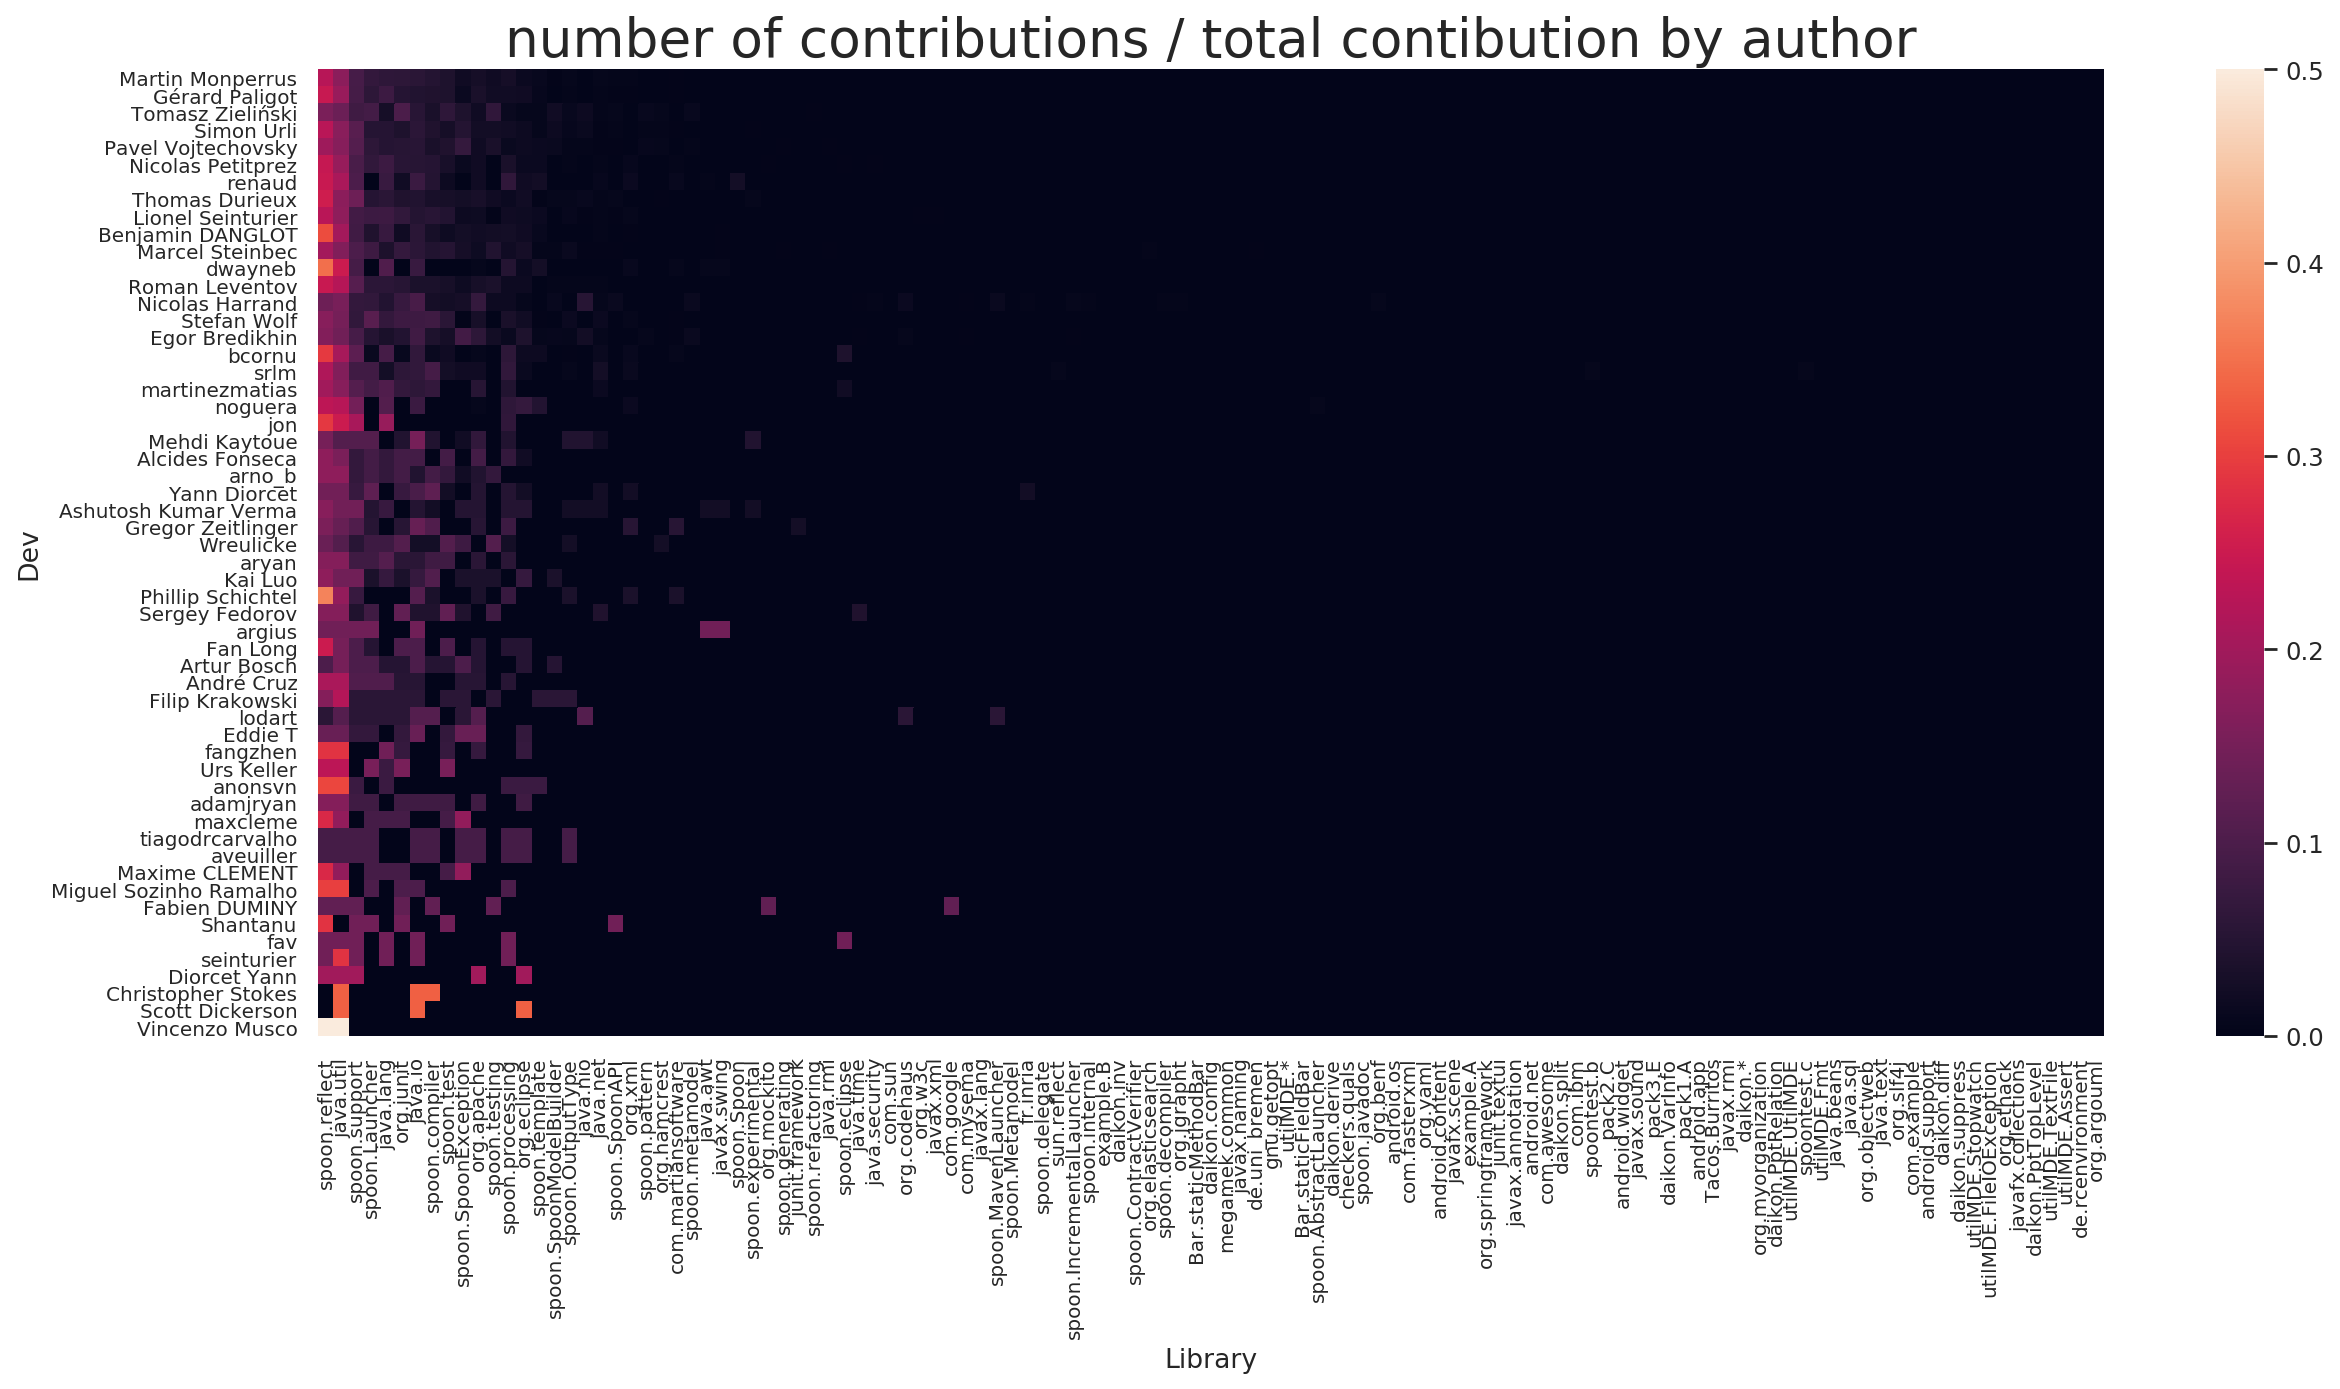

In [25]:
ratio_libcontrib_totcontrib = agreg_sorted.div(agreg_sorted.sum(axis=1), axis = 0)
plot_matrix(ratio_libcontrib_totcontrib, 'number of contributions / total contibution by author', xlabel='Library', ylabel='Dev')
plt.show()

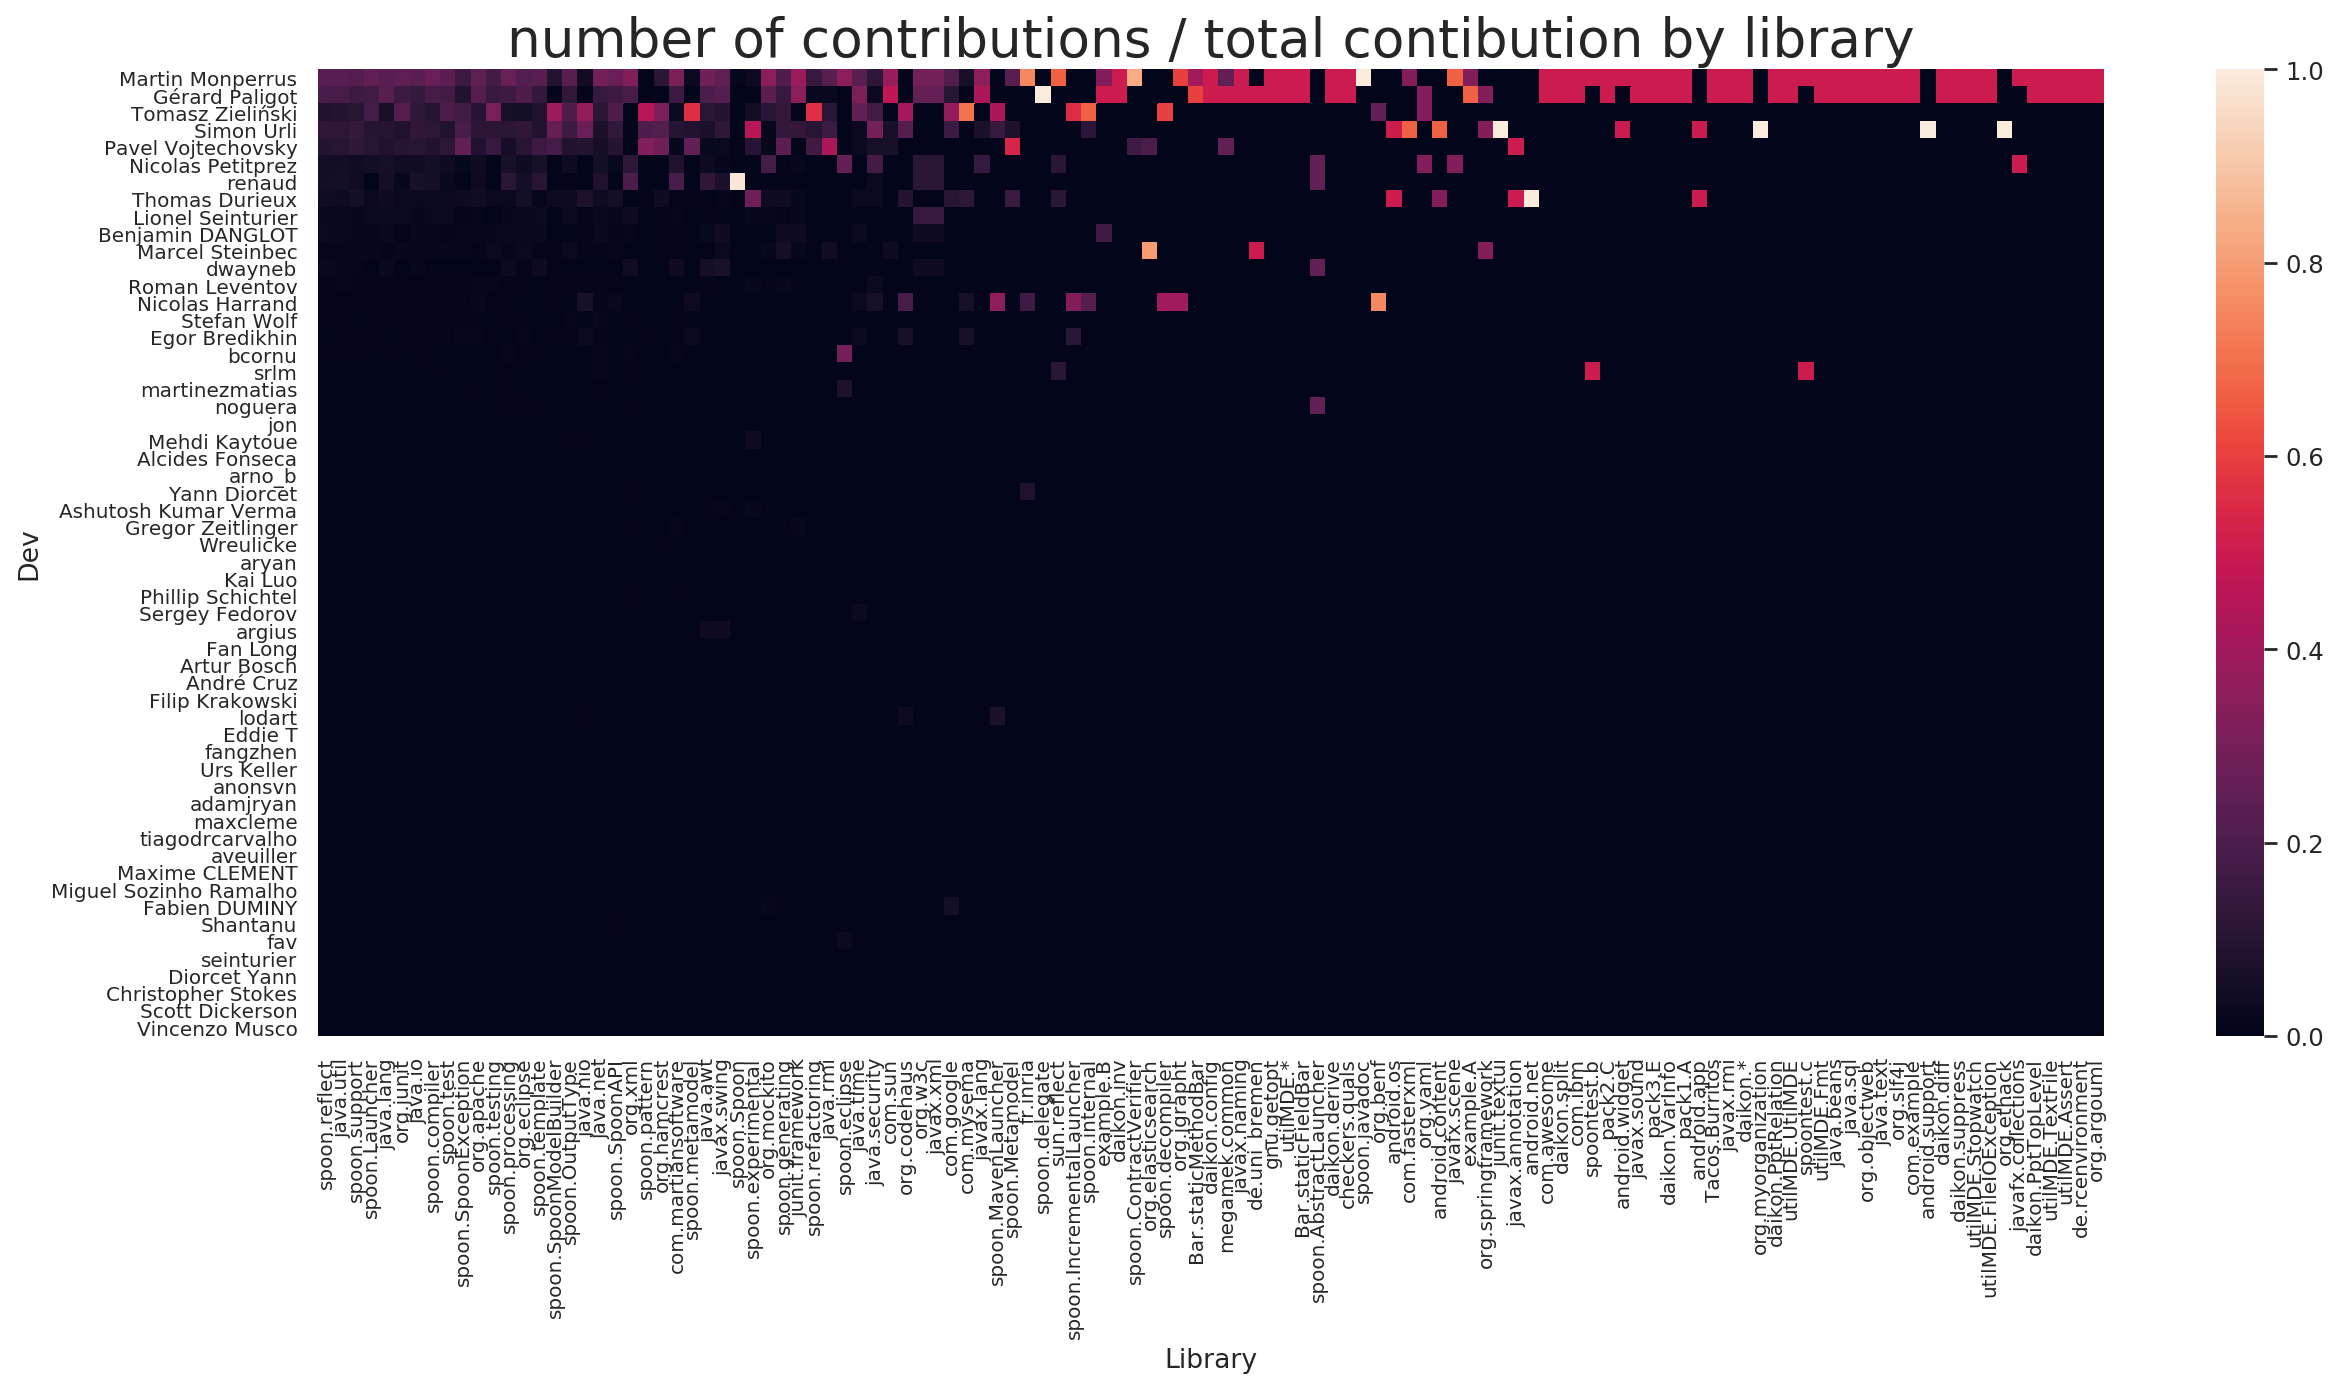

In [26]:
plot_matrix(agreg_sorted.div(agreg_sorted.sum(axis=0), axis = 1), 'number of contributions / total contibution by library', xlabel='Library', ylabel='Dev')
plt.show()

In [27]:
agreg_sorted.div(agreg_sorted.sum(axis=0), axis = 1).loc[:,'java.nio']

author
Martin Monperrus          0.045455
Gérard Paligot            0.009091
Tomasz Zieliński          0.369697
Simon Urli                0.269697
Pavel Vojtechovsky        0.093939
Nicolas Petitprez         0.000000
renaud                    0.000000
Thomas Durieux            0.075758
Lionel Seinturier         0.009091
Benjamin DANGLOT          0.006061
Marcel Steinbec           0.009091
dwayneb                   0.000000
Roman Leventov            0.009091
Nicolas Harrand           0.063636
Stefan Wolf               0.000000
Egor Bredikhin            0.024242
bcornu                    0.000000
srlm                      0.000000
martinezmatias            0.000000
noguera                   0.000000
jon                       0.000000
Mehdi Kaytoue             0.006061
Alcides Fonseca           0.000000
arno_b                    0.000000
Yann Diorcet              0.000000
Ashutosh Kumar Verma      0.003030
Gregor Zeitlinger         0.000000
Wreulicke                 0.000000
aryan        

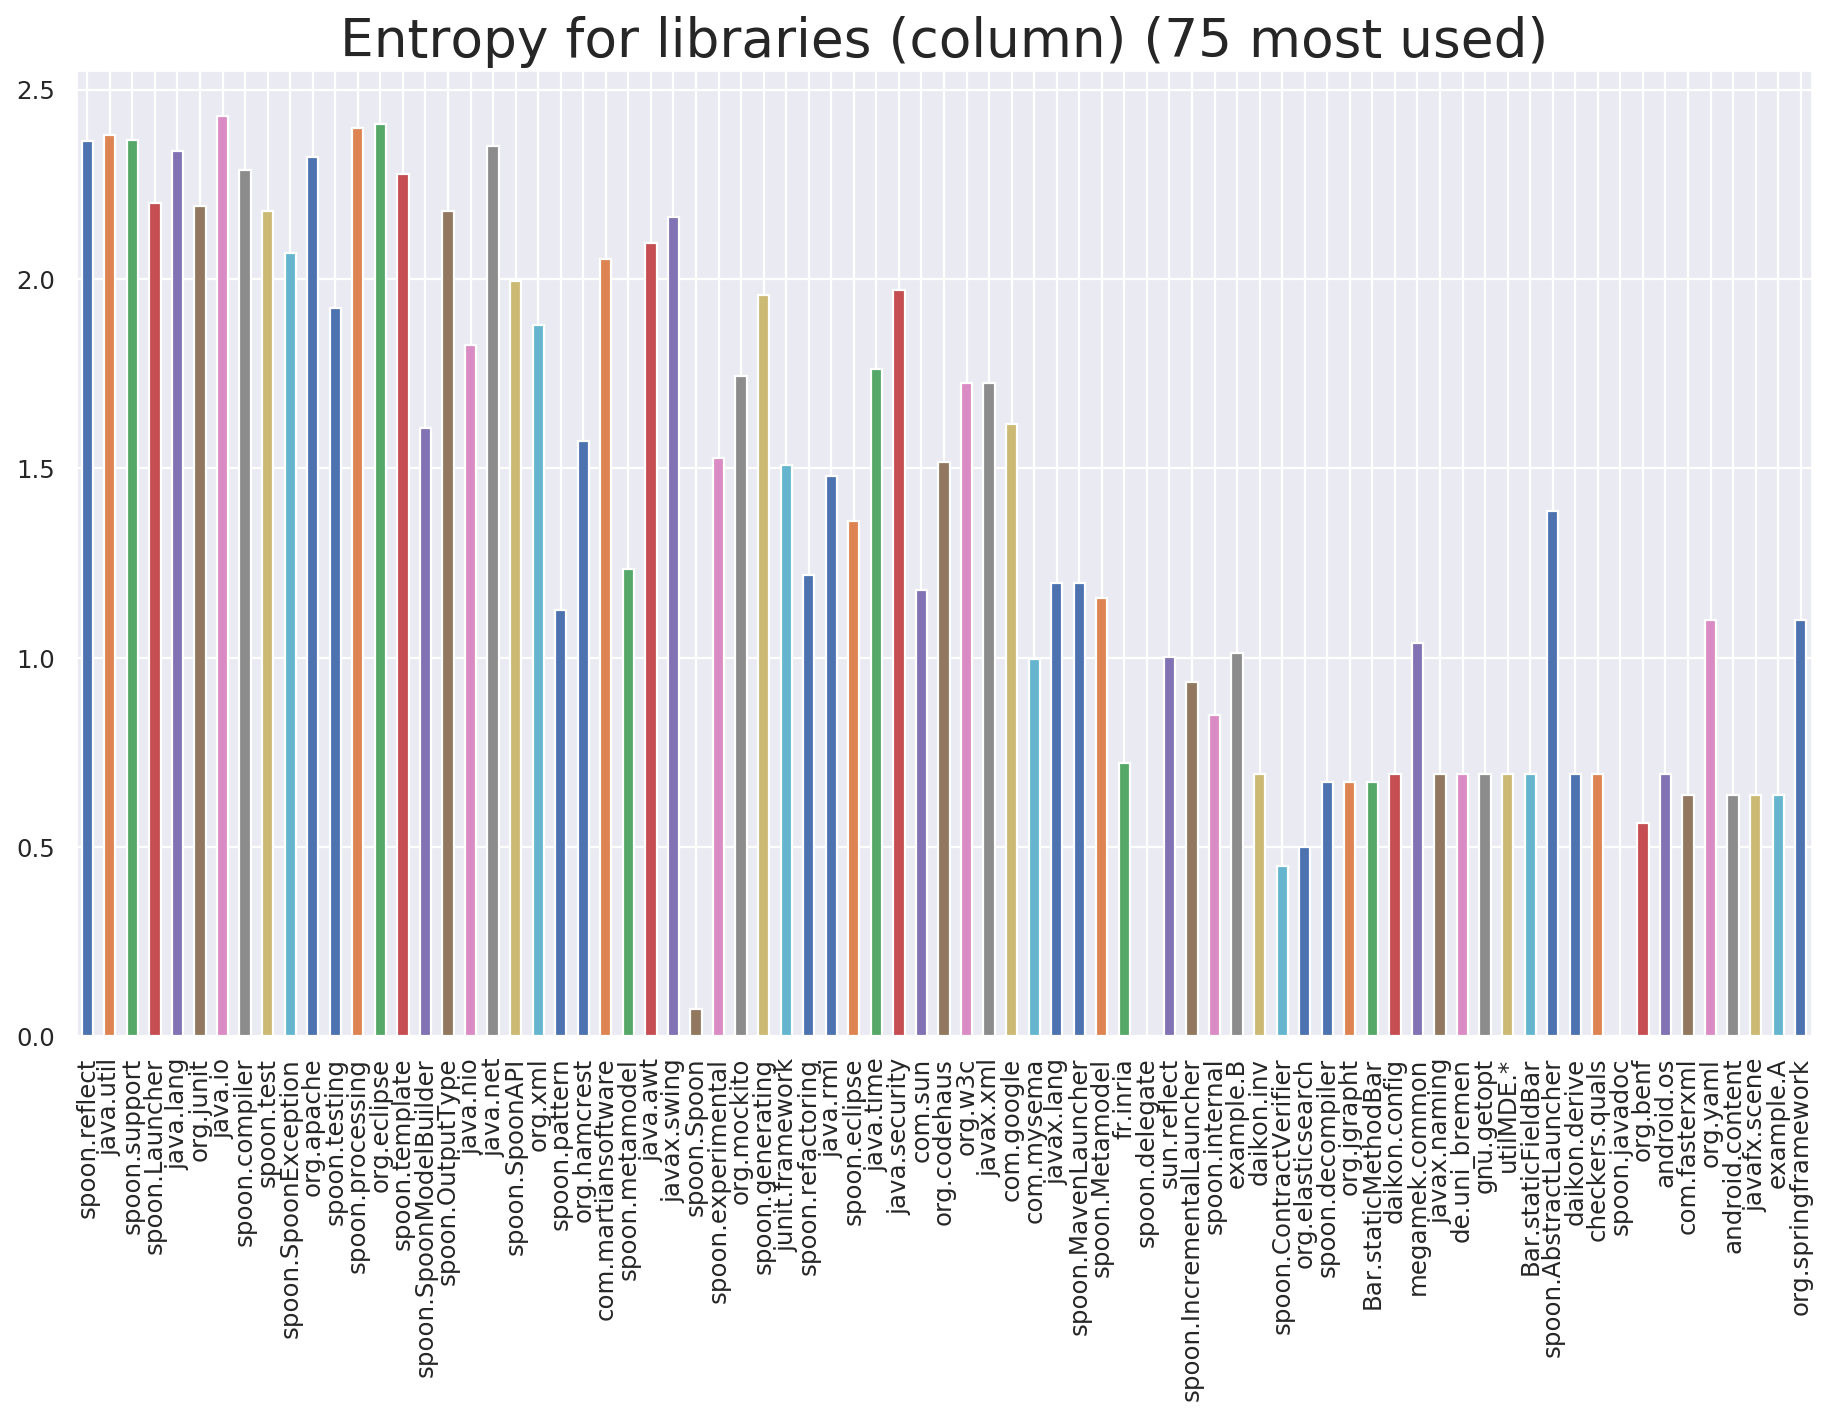

In [28]:
from scipy.stats import entropy

fig = plt.figure(figsize=(14, 8), dpi=160, facecolor='w', edgecolor='k')
#agreg_sorted.apply(lambda ligne: entropy(list(ligne.map(lambda x : int(x>=1))), 0).plot.bar()
agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 0).iloc[:77].plot.bar()
plt.title('Entropy for libraries (column) (75 most used)', fontsize=24)
plt.show()

Some libraries seam to contain more information than others, such as spoon.Launcher, junit.testing, org.xml, spoon.metatmodel, spoon.patttern, java.rmi, spoon.refactoring and spoon.eclipse.

Mostly it is spoon.* imports or testing import.

spoon.Spoon has been imported by very few users. Infact this must be a former package that has disappeared since then.

In [29]:
agreg_sorted['spoon.Spoon'].sort_values(ascending=False).head()

author
renaud                  71
Martin Monperrus         1
Stefan Wolf              0
Ashutosh Kumar Verma     0
Yann Diorcet             0
Name: spoon.Spoon, dtype: int64

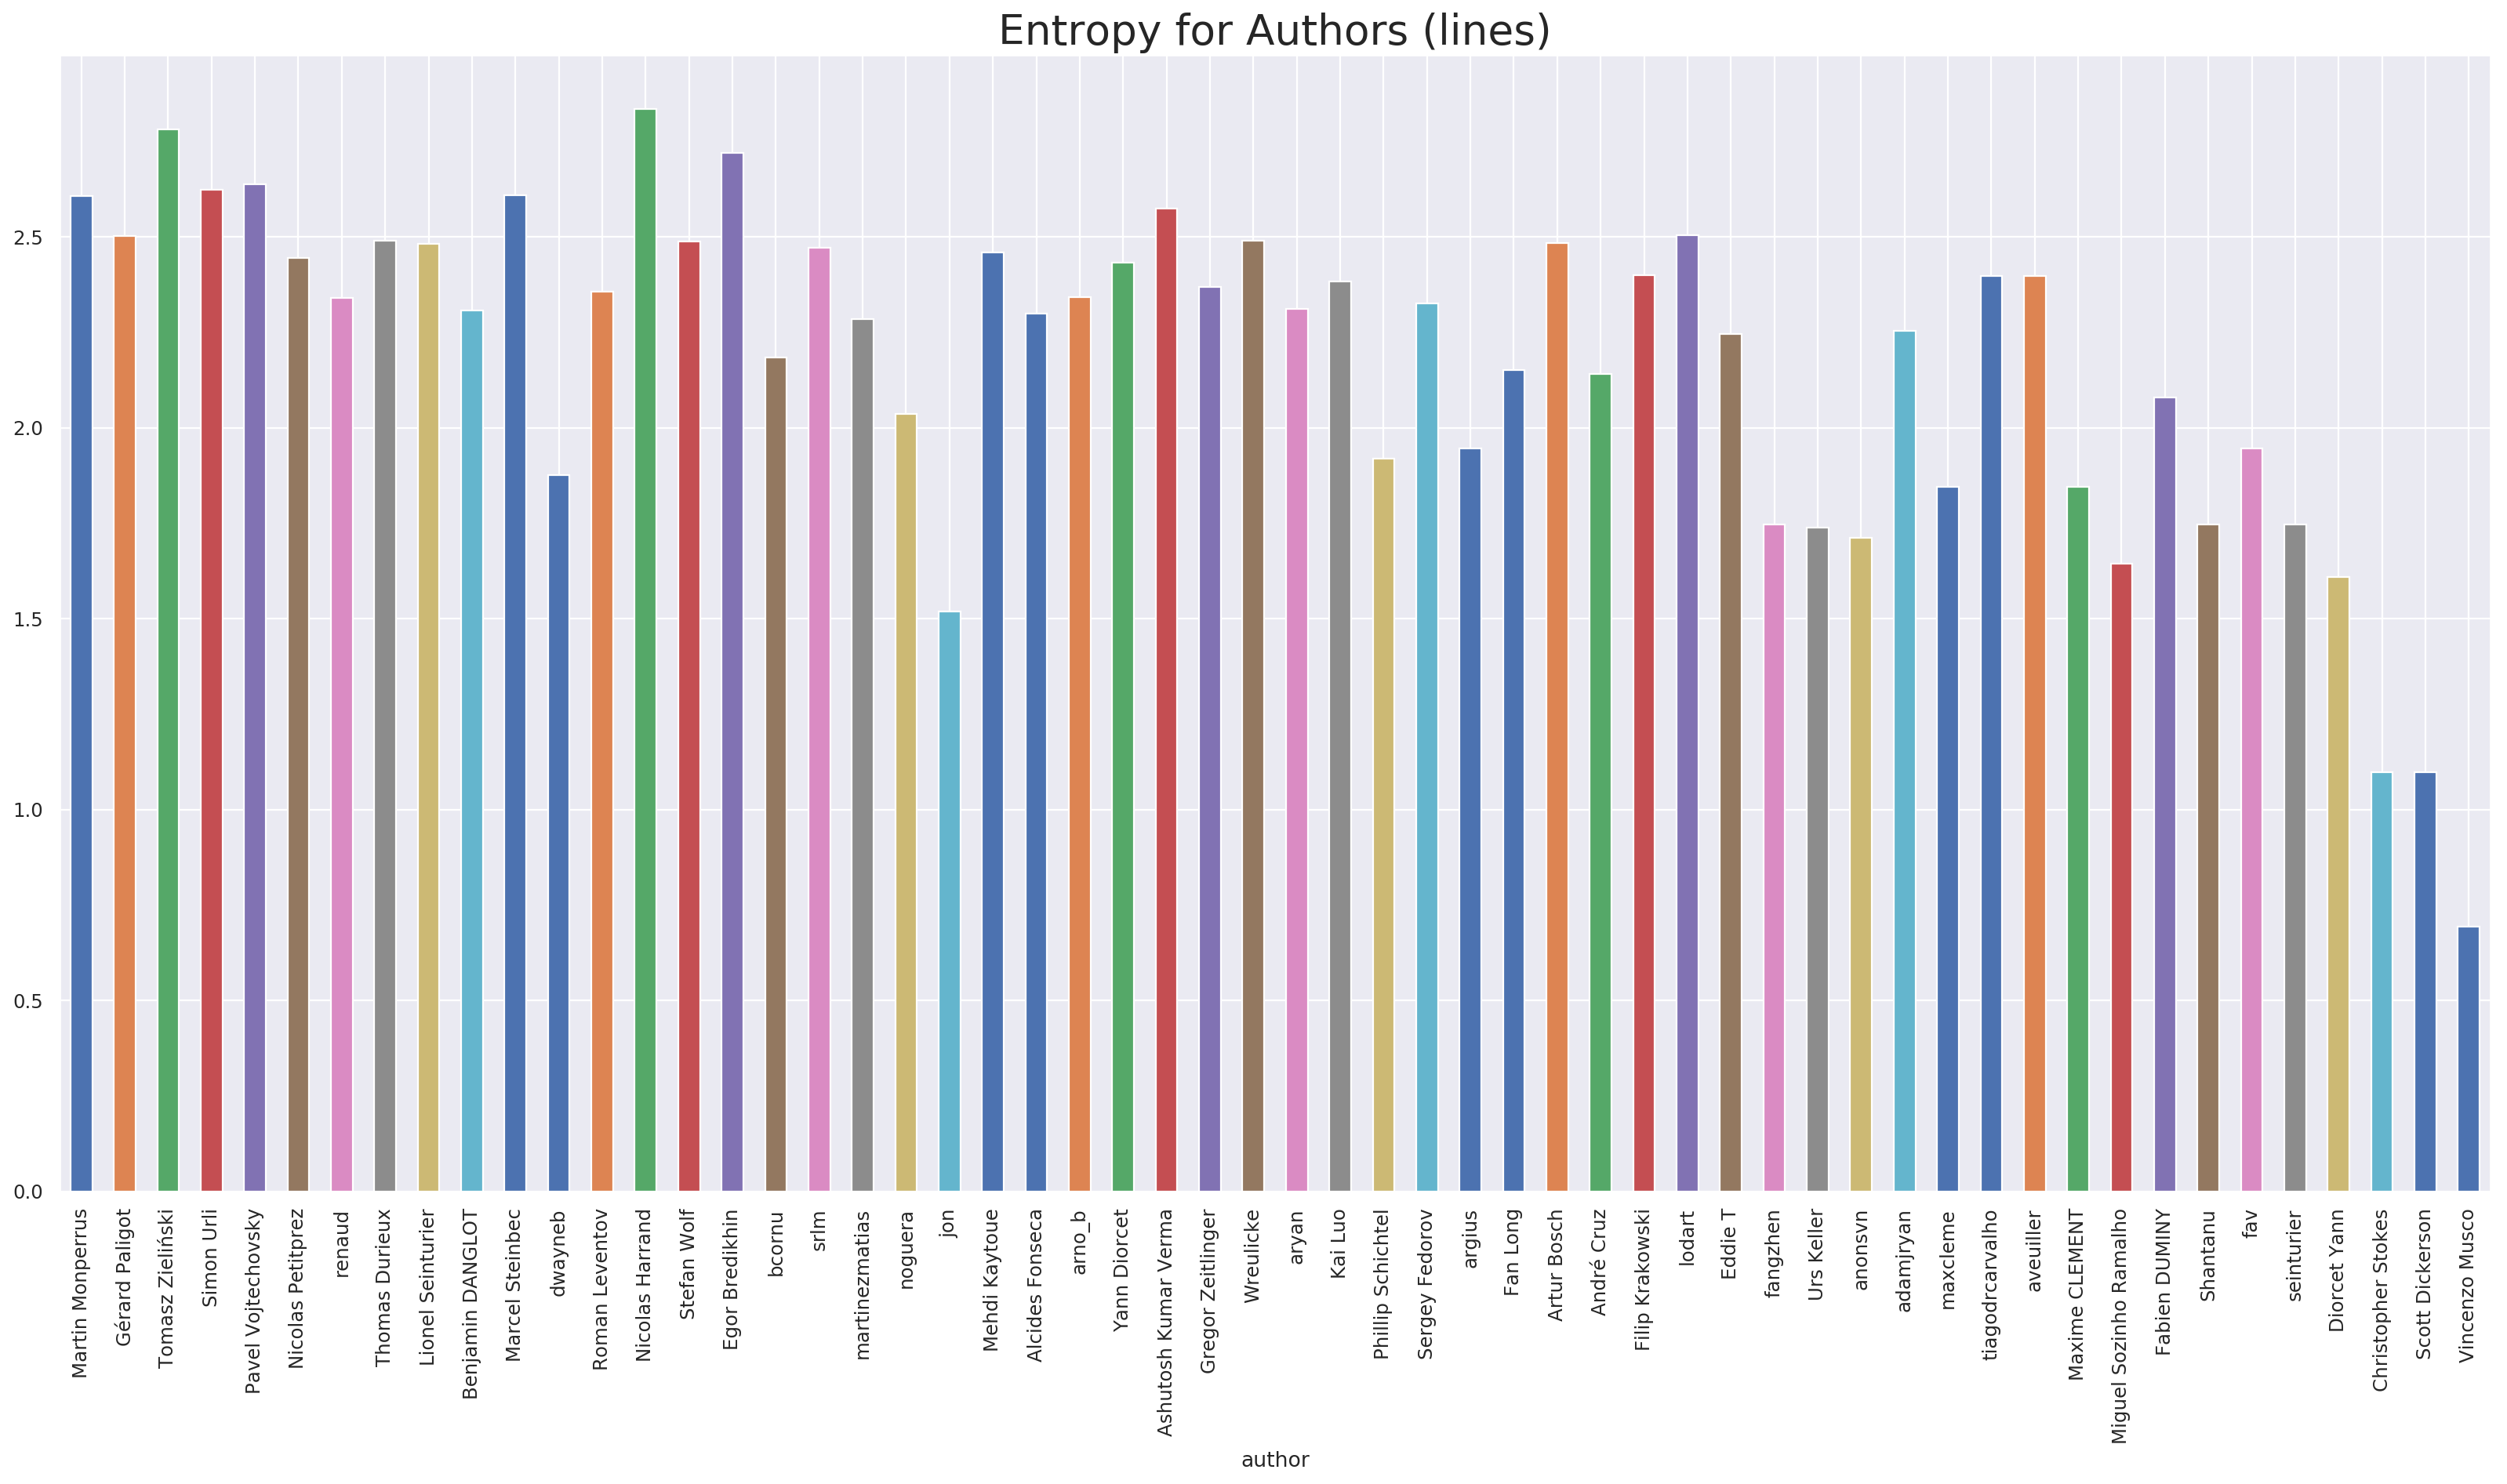

In [30]:
fig = plt.figure(figsize=(25, 12), dpi=160, facecolor='w', edgecolor='k')
# agreg_sorted.apply(lambda ligne: entropy(list(ligne.map(lambda x : int(x>=1)))), 1).plot.bar()
agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 1).plot.bar()
plt.title('Entropy for Authors (lines)', fontsize=24)
plt.show()

Who is renaud and what is spoon.Spoon ? 
And who is Jon ? 

In [31]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

def draw_vector(v0, v1, annotation='', ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='<-',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate(annotation, v0, v1, arrowprops=arrowprops)

def plot_pca(ax, df, pc1, pc2, pc3=None, labels=False, c=None, cmap='gnuplot', axis=None):
    if pc3 != None:
        scatter = ax.scatter(df.iloc[:,pc1], df.iloc[:,pc2], df.iloc[:,pc3], cmap=cmap, c=c)
    else:
        scatter = ax.scatter(df.iloc[:,pc1], df.iloc[:,pc2], cmap=cmap, c=c)
        if axis is not None:
            for (index, row) in axis.iterrows():
                draw_vector((0,0), (row.iloc[pc1], row.iloc[pc2]), index, ax=ax)
    if labels:
        for index, line in df.iterrows():
            if pc3 != None:
                ax.text(line.iloc[pc1], line.iloc[pc2], line.iloc[pc3], f'---{index}', fontsize=4)
            else:
                ax.text(line.iloc[pc1], line.iloc[pc2], f'---{index}', fontsize=4)
    ax.set_xlabel(f'PC{pc1+1}')
    ax.set_ylabel(f'PC{pc2+1}')
    if pc3 != None:
        ax.set_zlabel(f'PC{pc3+1}')
    return scatter

def quick_pca_plot(df, pc1, pc2, pc3=None, labels=False, c=None, cmap='gnuplot', axis=None, title=''):
    if pc3 != None:
        fig = plt.figure(figsize=(8, 6), dpi=160, constrained_layout=True)
        fig.suptitle(title)
        gs = GridSpec(2, 2, figure=fig)
        gs.update(wspace=0.5, hspace=0.5) # set the spacing between axes. 
        
        ax12 = fig.add_subplot(gs[0, 0])
        ax23 = fig.add_subplot(gs[0, 1])
        ax13 = fig.add_subplot(gs[1, 0])
        ax = fig.add_subplot(gs[1, 1], projection='3d')
        scatter3d = plot_pca(ax, df, pc1, pc2, pc3, labels=labels, c=c, cmap=cmap)
        plot_pca(ax12, df, pc1, pc2, labels=labels, c=c, cmap=cmap)
        plot_pca(ax23, df, pc2, pc3, labels=labels, c=c, cmap=cmap)
        plot_pca(ax13, df, pc1, pc3, labels=labels, c=c, cmap=cmap)
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        if c is not None:
            fig.colorbar(scatter3d, cax=cbar_ax)
    else:
        fig = plt.figure(figsize=(6, 6), dpi=160, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)
        scatter = plot_pca(ax, df, pc1, pc2, labels=labels, c=c, cmap=cmap, axis=axis)
        if c is not None:
            plt.colorbar(scatter)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


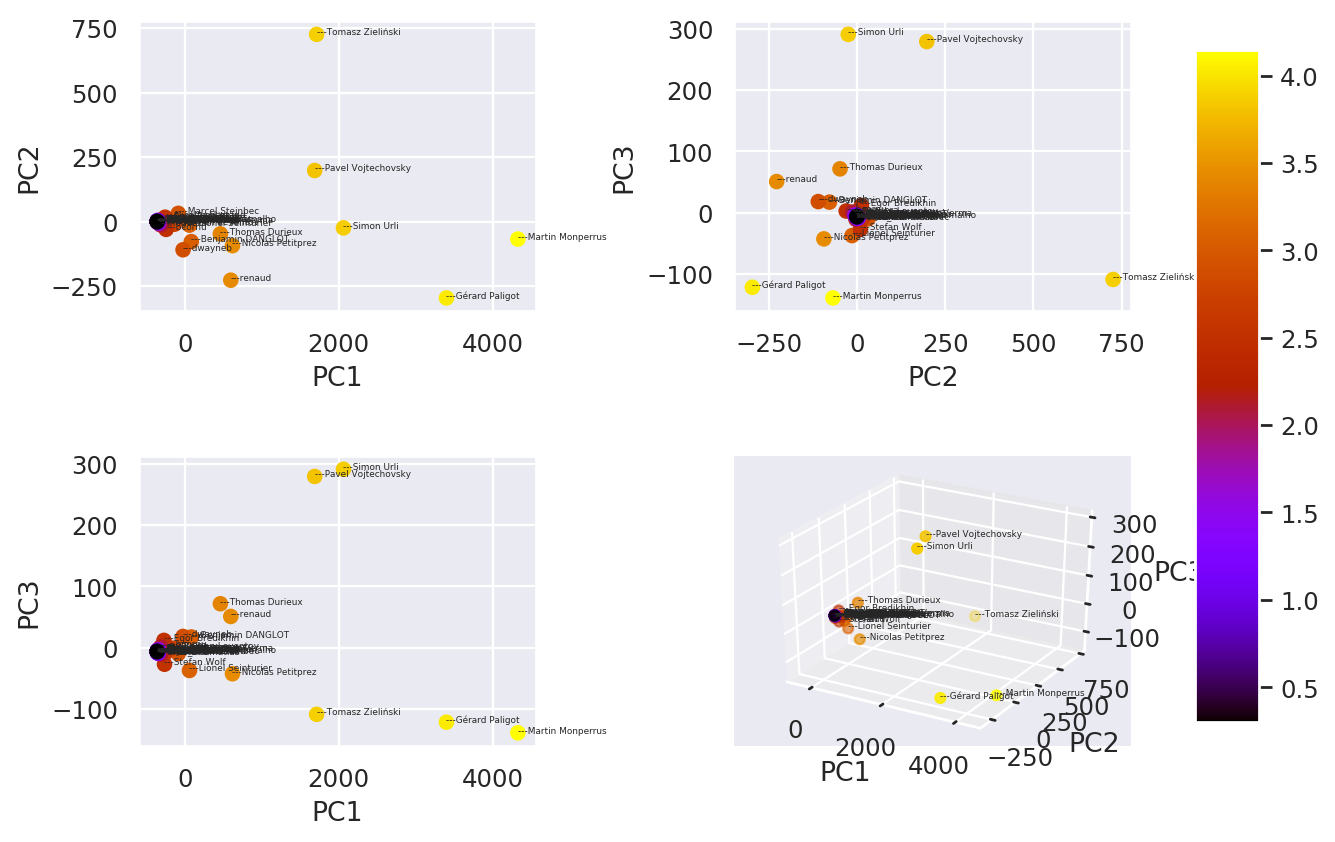

In [32]:
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(agreg_sorted)

principalDf = pd.DataFrame(data = principalComponents, index = ratio_libcontrib_totcontrib.index
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#quick_pca_plot(top , 0, 1, 2, labels=True, c=y_kmeans, cmap='Set1')
quick_pca_plot(principalDf, 0, 1, pc3=2, labels=True, c=np.log10(number_of_contibs))
save_fig('pca_raw_data')
plt.show()

### Nomalisation L2

Gaol : Remove the effect of size 

Downsides : tends to delete the effect of small libraries

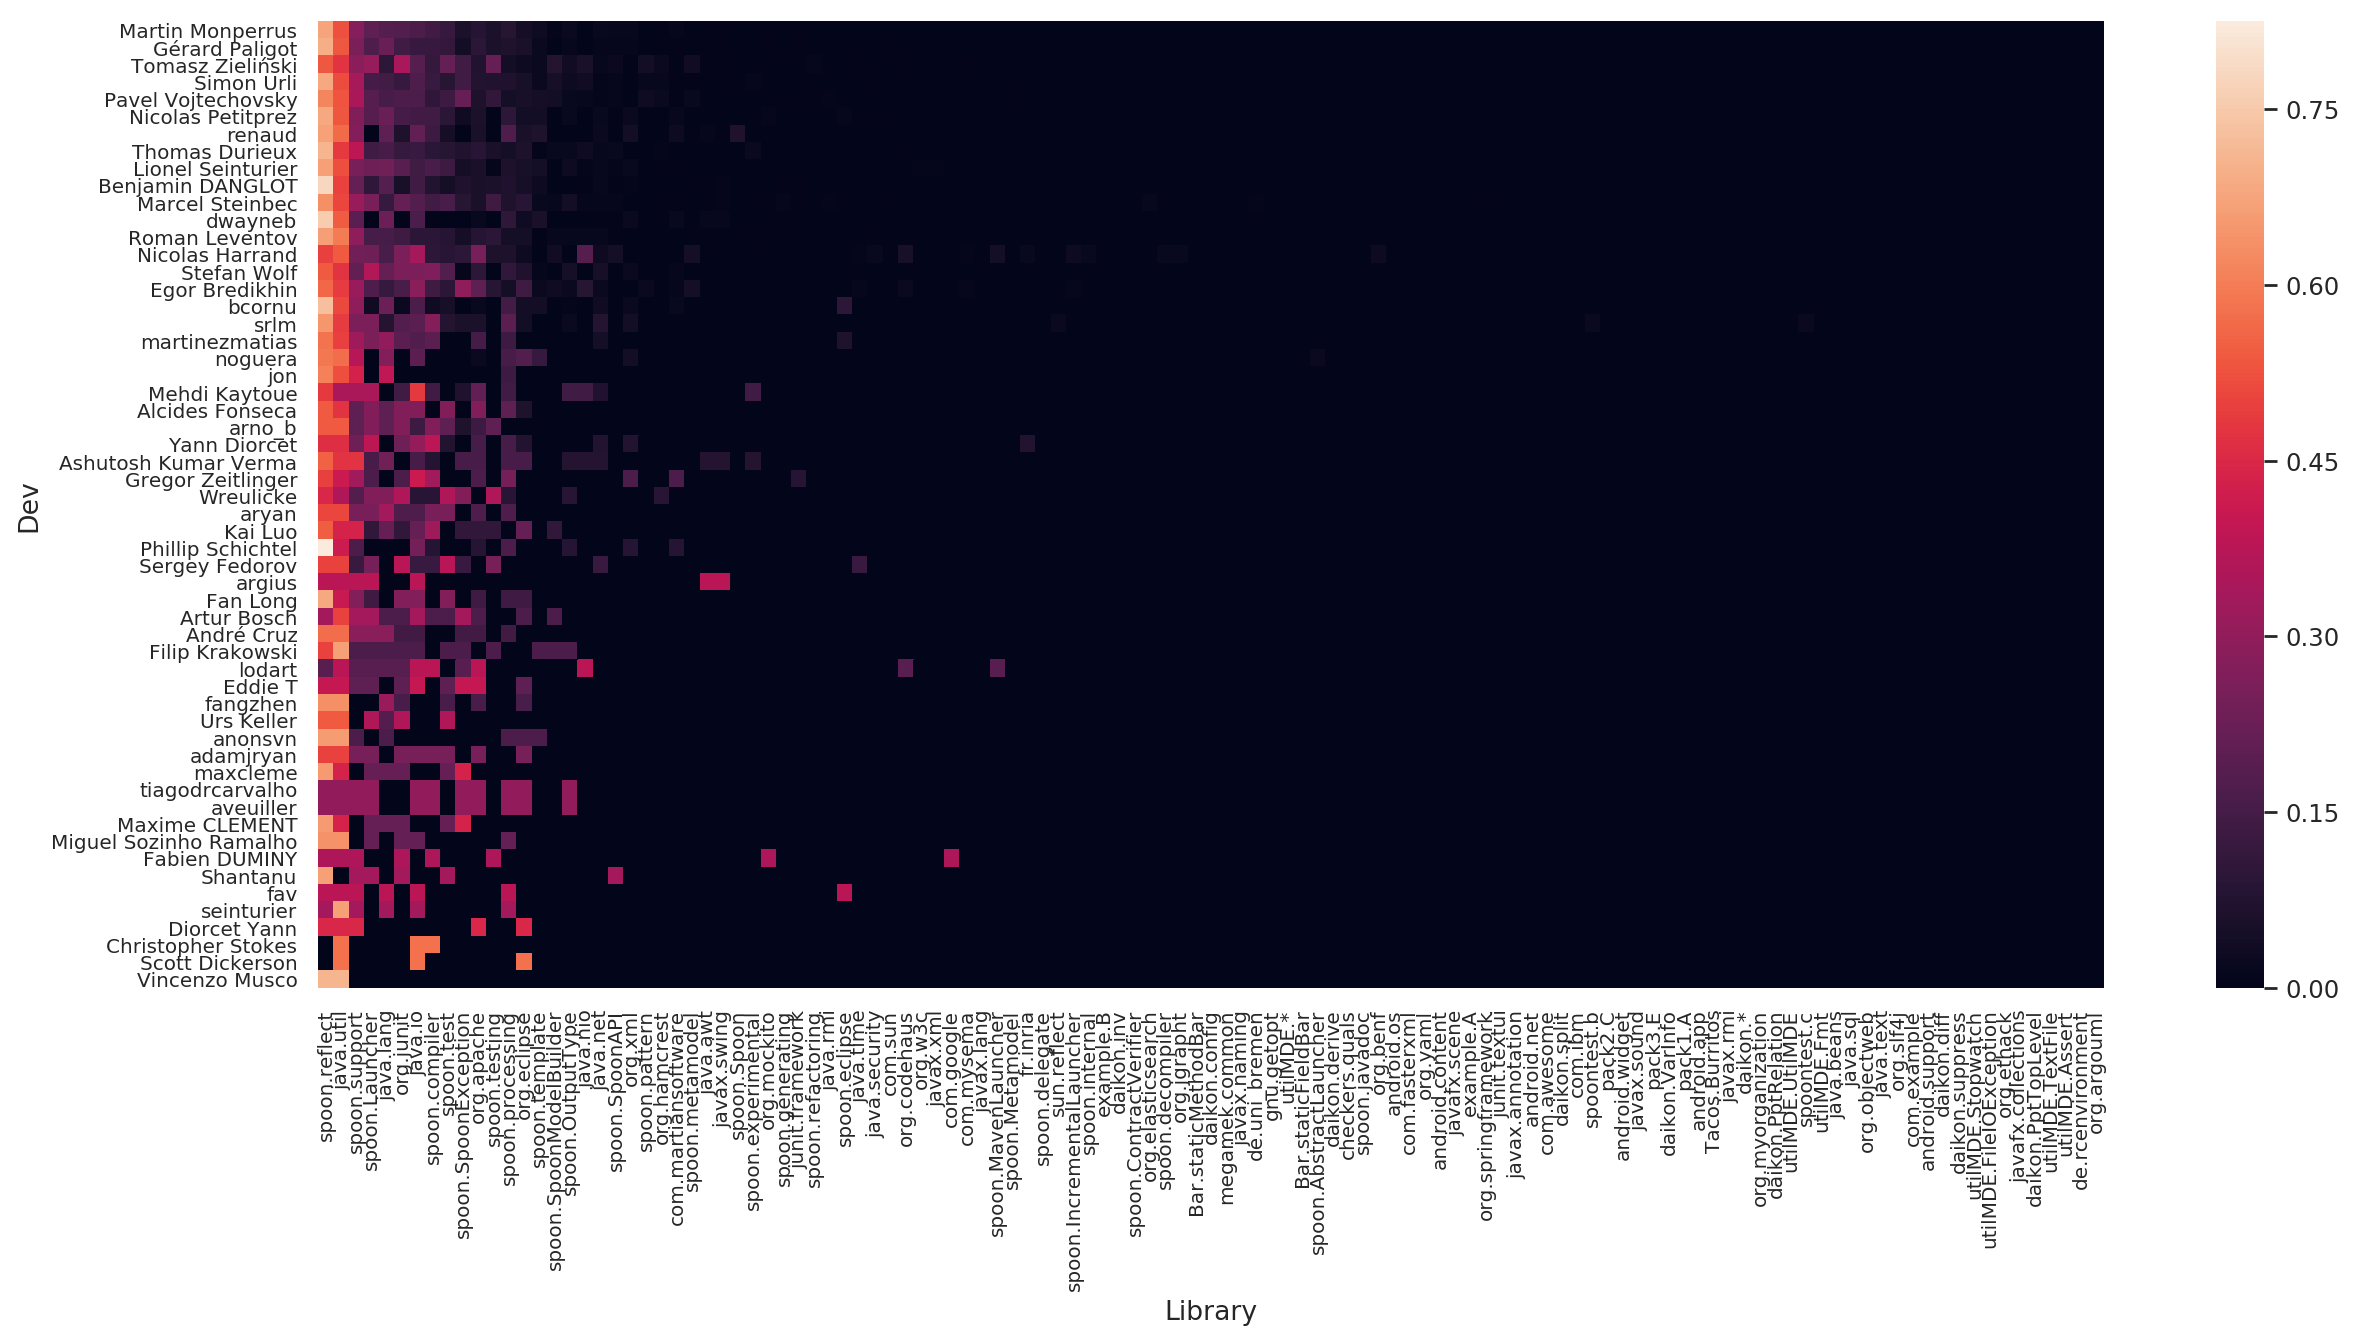

In [33]:
agreg_normalized = agreg_sorted.div(np.sqrt(agreg_sorted.pow(2).sum(axis=1)), axis=0)
plot_matrix(agreg_normalized, '', xlabel='Library', ylabel='Dev')
save_fig('author_lib_L2')
plt.show()

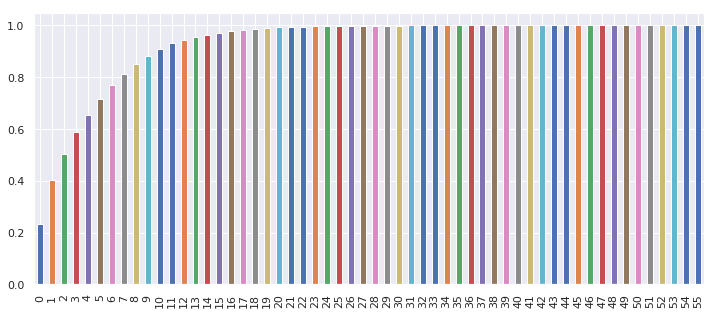

0.401908249384


In [34]:
pca = PCA()

principalComponents = pca.fit_transform(agreg_normalized)

plt.figure(figsize=(12,5))
pd.Series(np.cumsum(pca.explained_variance_ratio_)).plot.bar()
save_fig('explained_variance_L2')
plt.show()
print(np.sum(pca.explained_variance_ratio_[:2]))

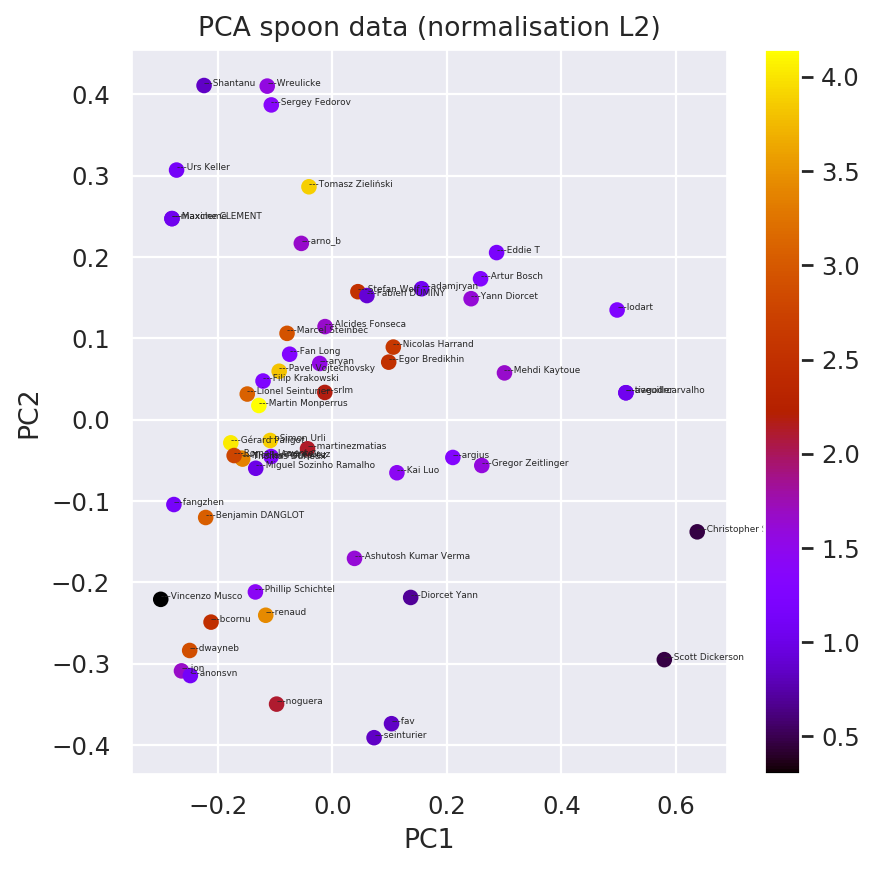

In [35]:
axis_transform = pca.transform(np.diag([1]*len(agreg_normalized.columns)))
axis_transform_df = pd.DataFrame(data = axis_transform[:,:2], index = agreg_normalized.columns
             , columns = ['principal component 1', 'principal component 2'])

principalDf = pd.DataFrame(data = principalComponents[:,:3], index = agreg_normalized.index
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

quick_pca_plot(principalDf, 0, 1, labels=True, c=np.log10(number_of_contibs))
#quick_pca_plot(principalDf, 0, 1, labels=True, c=np.log10(number_of_contibs), axis=axis_transform_df)
plt.title('PCA spoon data (normalisation L2)')
save_fig('pca_L2')
plt.show()

axis_transform_df_top = axis_transform_df[np.sqrt(axis_transform_df.pow(2).sum(axis=1)) > np.sort(np.sqrt(axis_transform_df.pow(2).sum(axis=1)))[-20]]

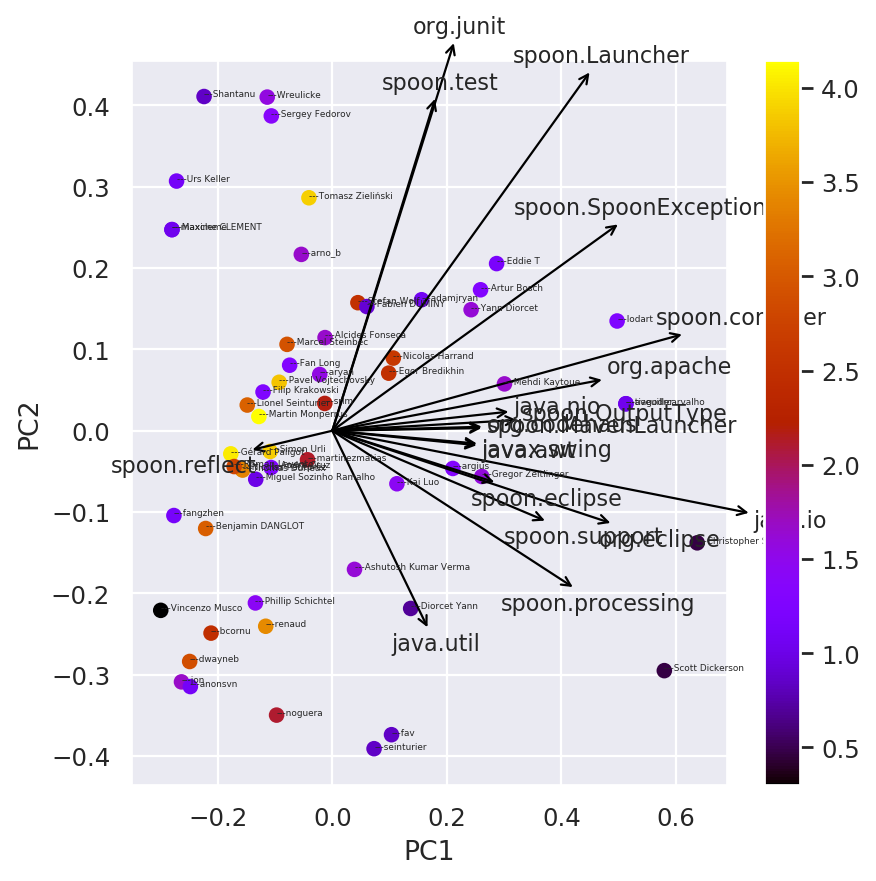

In [36]:
quick_pca_plot(principalDf, 0, 1, labels=True, c=np.log10(number_of_contibs), axis=axis_transform_df_top)
save_fig('pca_L2_axis')
plt.show()

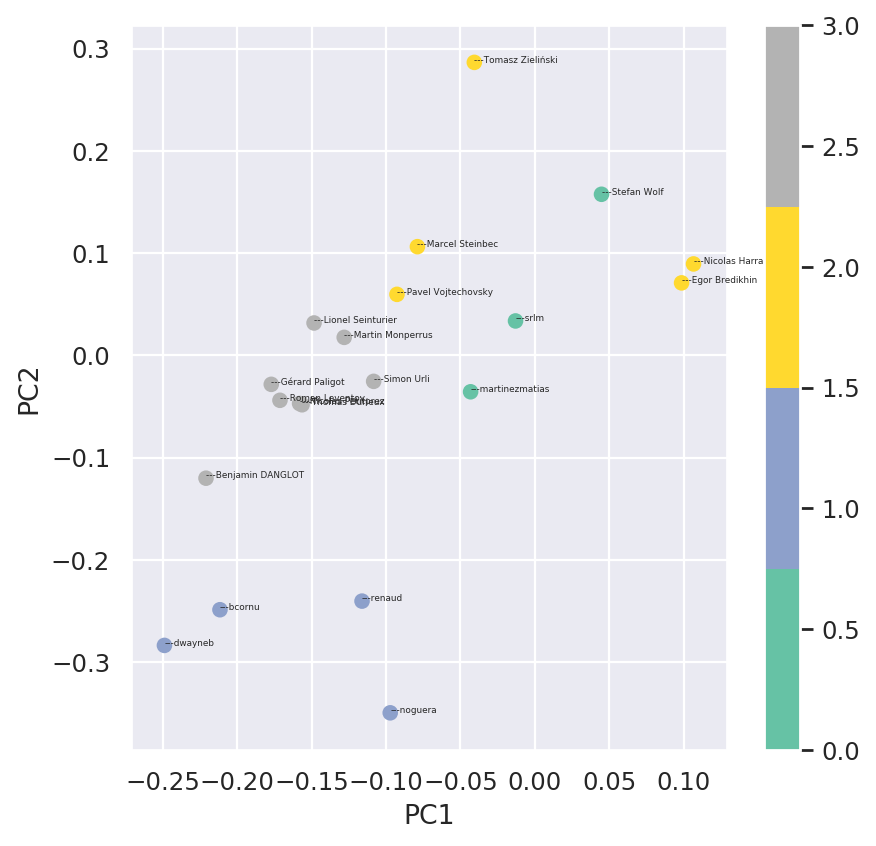

In [37]:
from sklearn.cluster import KMeans # or GaussianMixture ? 


top = principalDf.loc[number_of_contibs > 100]
top_agreg = agreg_normalized.loc[number_of_contibs > 100]

n_clusters = 4
colors = plt.cm.get_cmap('Set2', n_clusters)

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=100).fit(top_agreg)

y_kmeans = kmeans.predict(top_agreg)

quick_pca_plot(top , 0, 1, labels=True, c=y_kmeans, cmap=colors)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


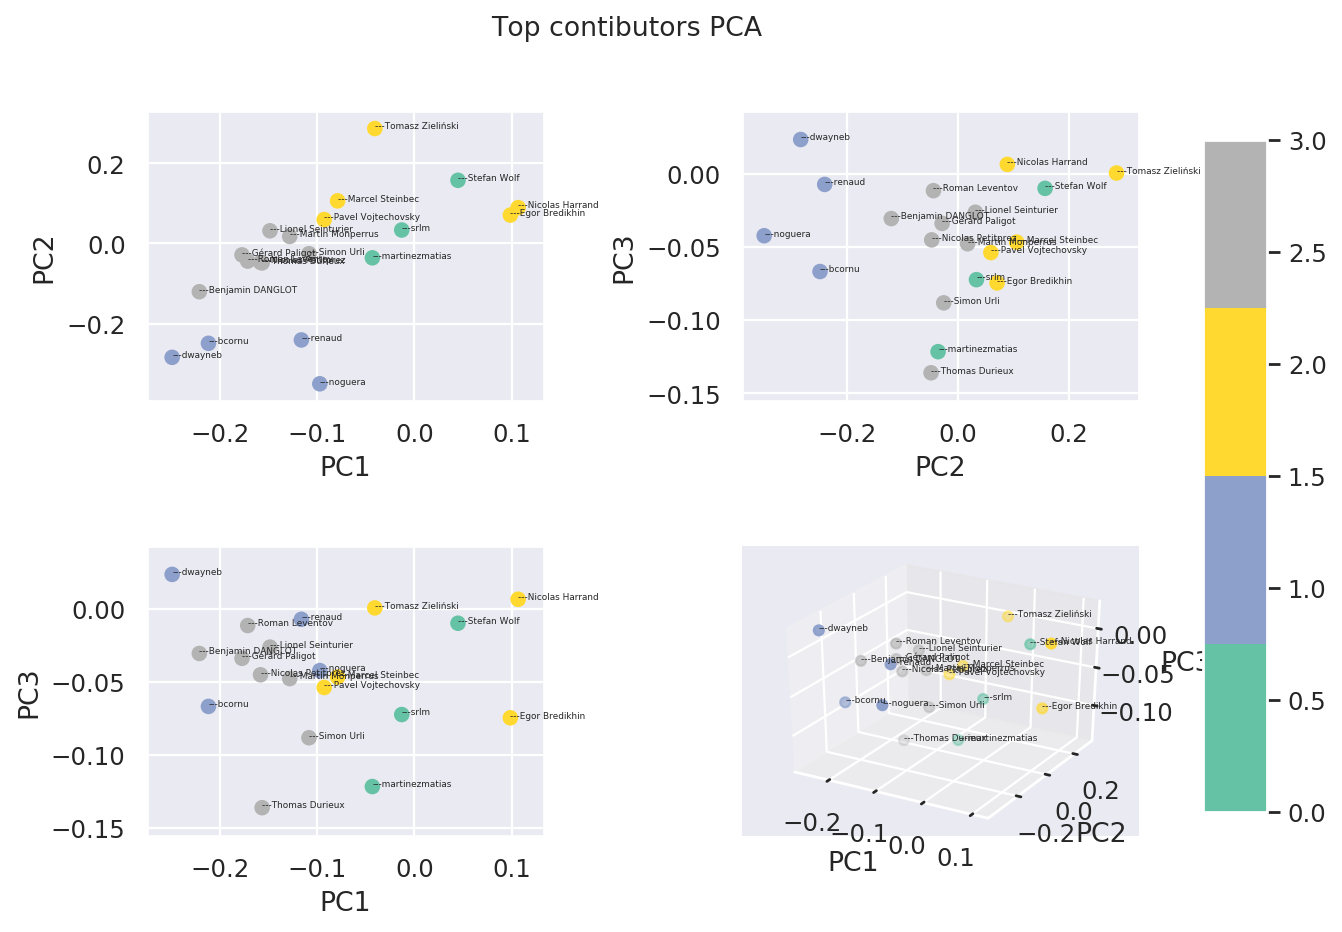

In [38]:
quick_pca_plot(top , 0, 1, 2, labels=True, c=y_kmeans, cmap=colors, title='Top contibutors PCA')
save_fig('pca_top_3d_clusters')
plt.show()

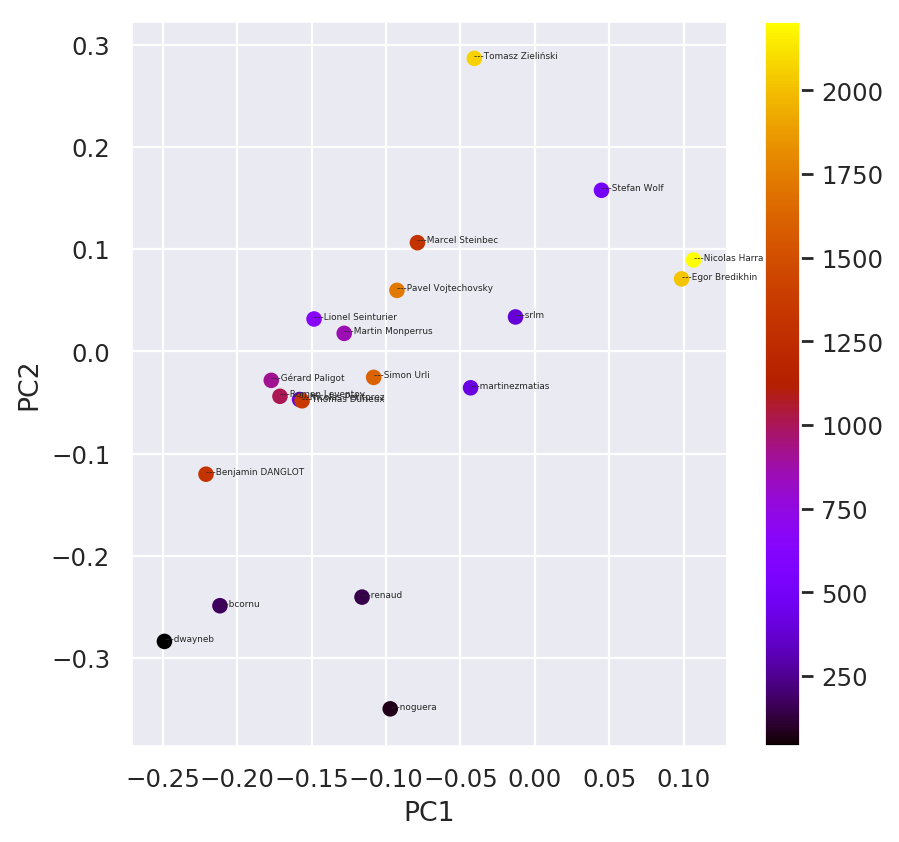

In [39]:
top_avg_contib = avg_contrib.loc[top.index, 'index'].loc[:,'mean']

quick_pca_plot(top , 0, 1, labels=True, c=top_avg_contib)

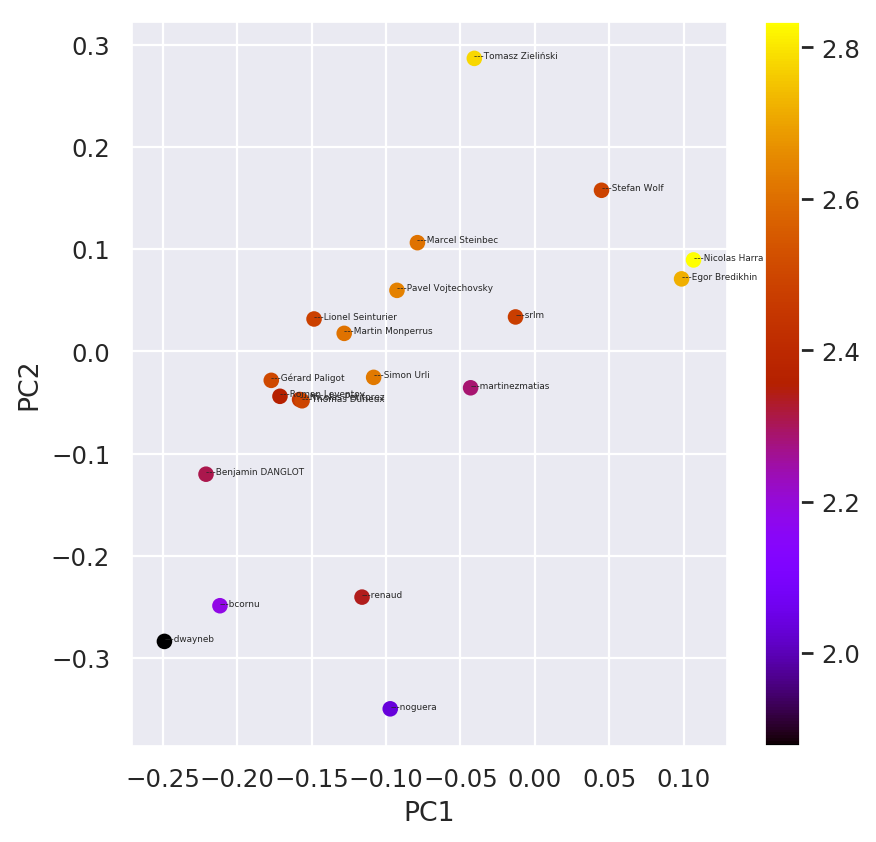

In [40]:
quick_pca_plot(top, 0, 1, labels=True, c=agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 1).loc[top.index])
plt.show()

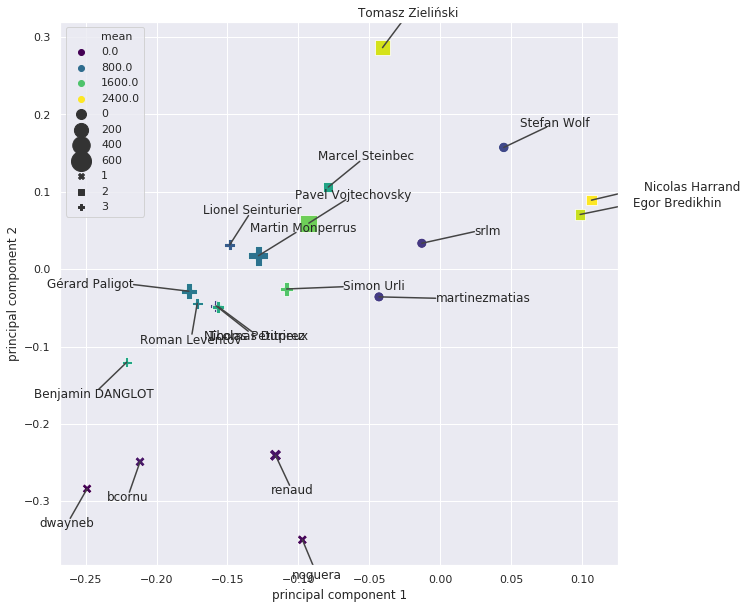

In [41]:
plt.figure(figsize=(10,10))
data = {
    'pc1': top['principal component 1'],
    'pc2': top['principal component 2'],
    'avg_contib': top_avg_contib,
    'cluster': y_kmeans,
    'Number of commits': avg_contrib.loc[top.index, 'index'].loc[:,'count'].values
}
cmap = sns.cubehelix_palette(as_cmap=True)
scatter = sns.scatterplot(x='pc1',y='pc2', data = data, hue = 'avg_contib', palette='viridis', style='cluster', size='Number of commits', sizes=(100, 400))
center_x = -0.17
center_y = -0.03
for index, line in top.iterrows():
    pos_x = line.loc['principal component 1']
    pos_y = line.loc['principal component 2']
    norm = np.sqrt((pos_x-center_x)**2 + (pos_y-center_y)**2)
    offset_x = (pos_x-center_x)/norm * 0.04
    offset_y = (pos_y-center_y)/norm * 0.04
    offset_text_x = (pos_x-center_x)/norm * 0.0475
    offset_text_y = (pos_y-center_y)/norm * 0.0475
    horizontalalignment = 'center'
    if abs(offset_y/offset_x) < 0.5:
        horizontalalignment = 'right' if offset_x<0 else 'left'
        offset_text_y = offset_y
        offset_text_x = offset_x
    text_value = f'{index}'
    l = mlines.Line2D([pos_x,pos_x+offset_x], [pos_y,pos_y + offset_y], color='#444444')
    scatter.add_line(l)
    t = scatter.text(pos_x + offset_text_x, pos_y + offset_text_y, text_value, fontsize=12, va='center',horizontalalignment=horizontalalignment)
save_fig('PCA_all')
plt.show()

Time seems to have an influence on the results. Clearly, the red cluster at the bottom left represent the oldest contributors (who are no longer active). On the other hand, we can see that the black cluster (top right) are the recent contributors. 

I see two major explanations : 
- Trends during the development of the software (the team will focus on certain parts of the project over the years)
- The packages used in the project change over time

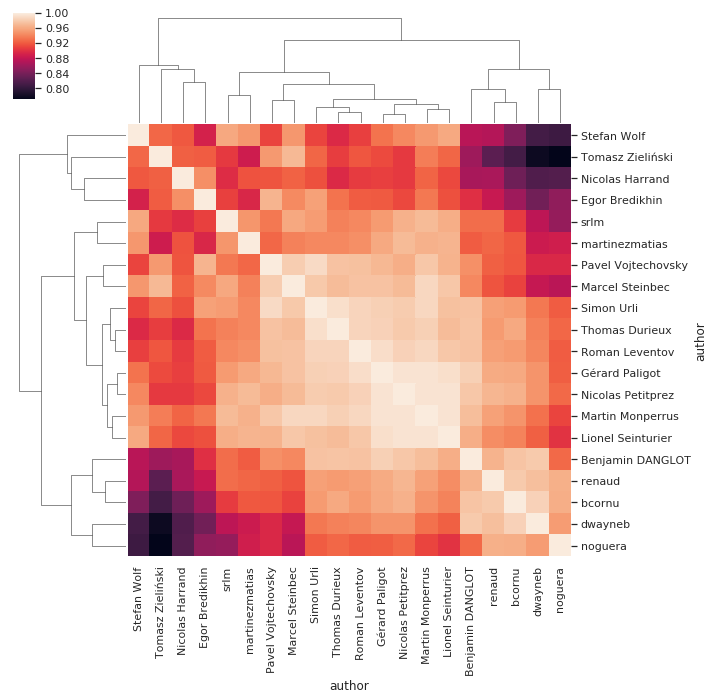

In [42]:
agreg_product = pd.DataFrame(np.matrix(top_agreg) * np.transpose(np.matrix(top_agreg)))
agreg_product.index = top_agreg.index
agreg_product.columns = top_agreg.index

sns.clustermap(agreg_product)
save_fig('similarity_clustermap')
plt.plot();

In [43]:
libraries_distance.shape

(117, 117)

Index(['srlm', 'Stefan Wolf', 'martinezmatias', 'noguera', 'bcornu', 'renaud',
       'dwayneb', 'Tomasz Zieliński', 'Pavel Vojtechovsky', 'Egor Bredikhin',
       'Nicolas Harrand', 'Marcel Steinbec', 'Martin Monperrus',
       'Lionel Seinturier', 'Thomas Durieux', 'Nicolas Petitprez',
       'Simon Urli', 'Gérard Paligot', 'Roman Leventov', 'Benjamin DANGLOT'],
      dtype='object', name='author')


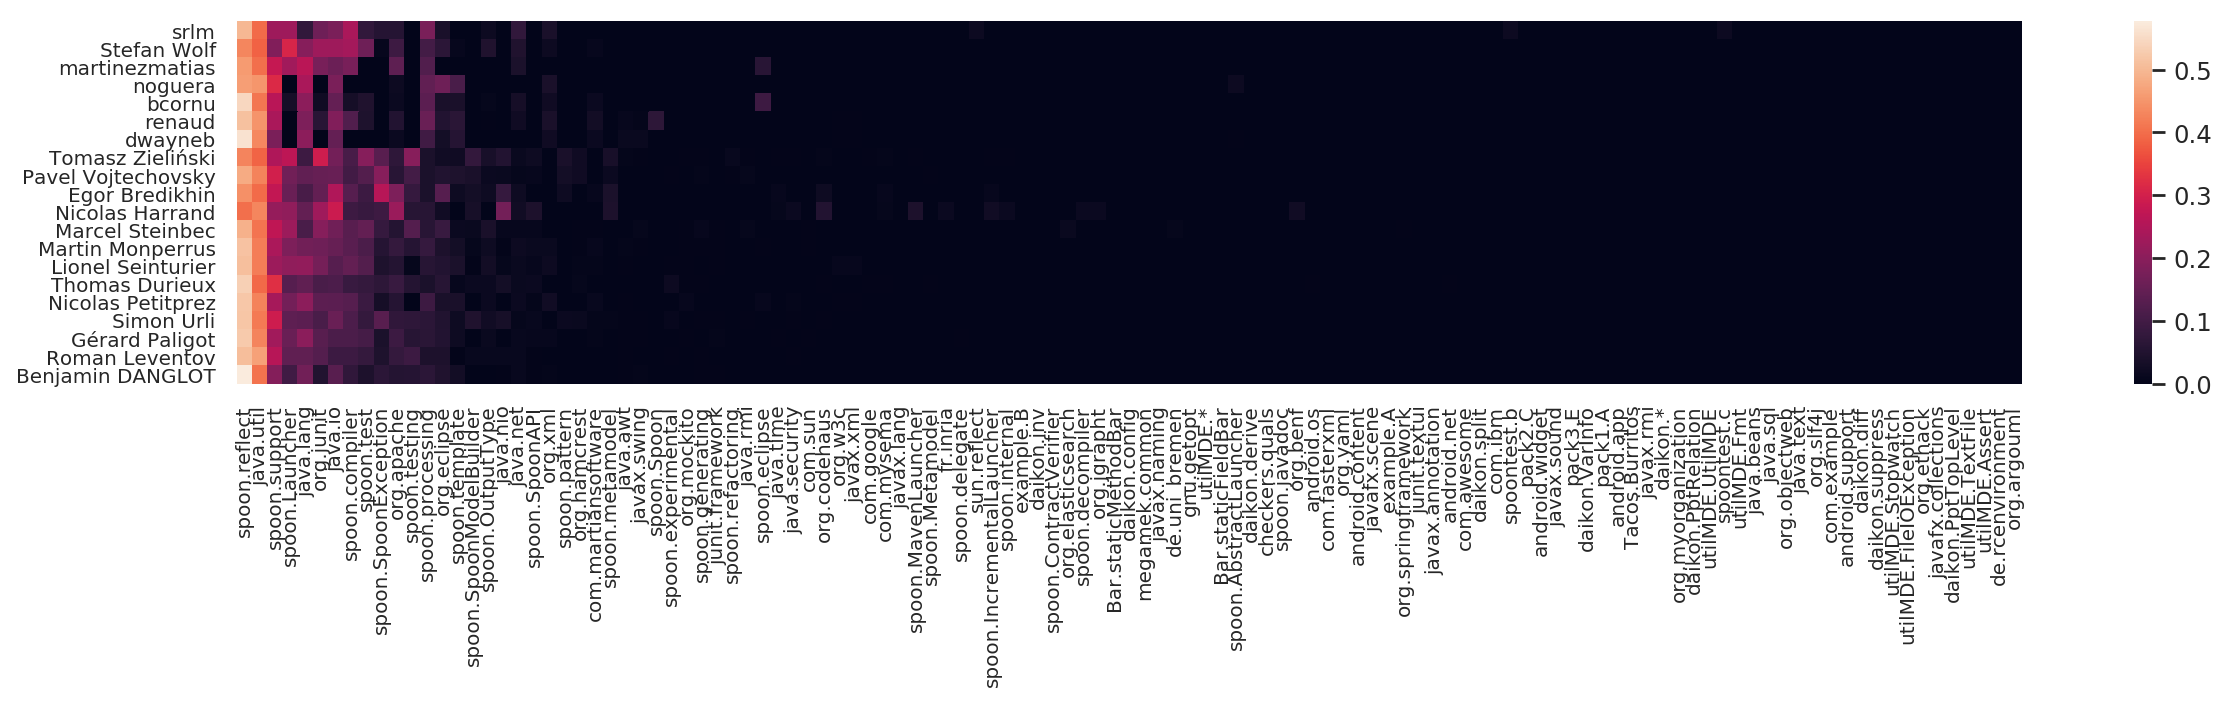

In [44]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=100).fit(top_agreg)
y_kmeans = kmeans.predict(top_agreg)
index_cluster = np.array(kmeans.labels_).argsort()

plot_matrix(np.log(1+top_agreg.iloc[index_cluster]), title='', figsize=(18,3))
print(top_agreg.iloc[index_cluster].index)

Let's try to give more weight to small packages by changing the normalization used.

### Expertise 

In [45]:
top_top = agreg_sorted.loc[agreg_sorted.sum(axis=1) > 100, :]
top_top.shape

(20, 117)

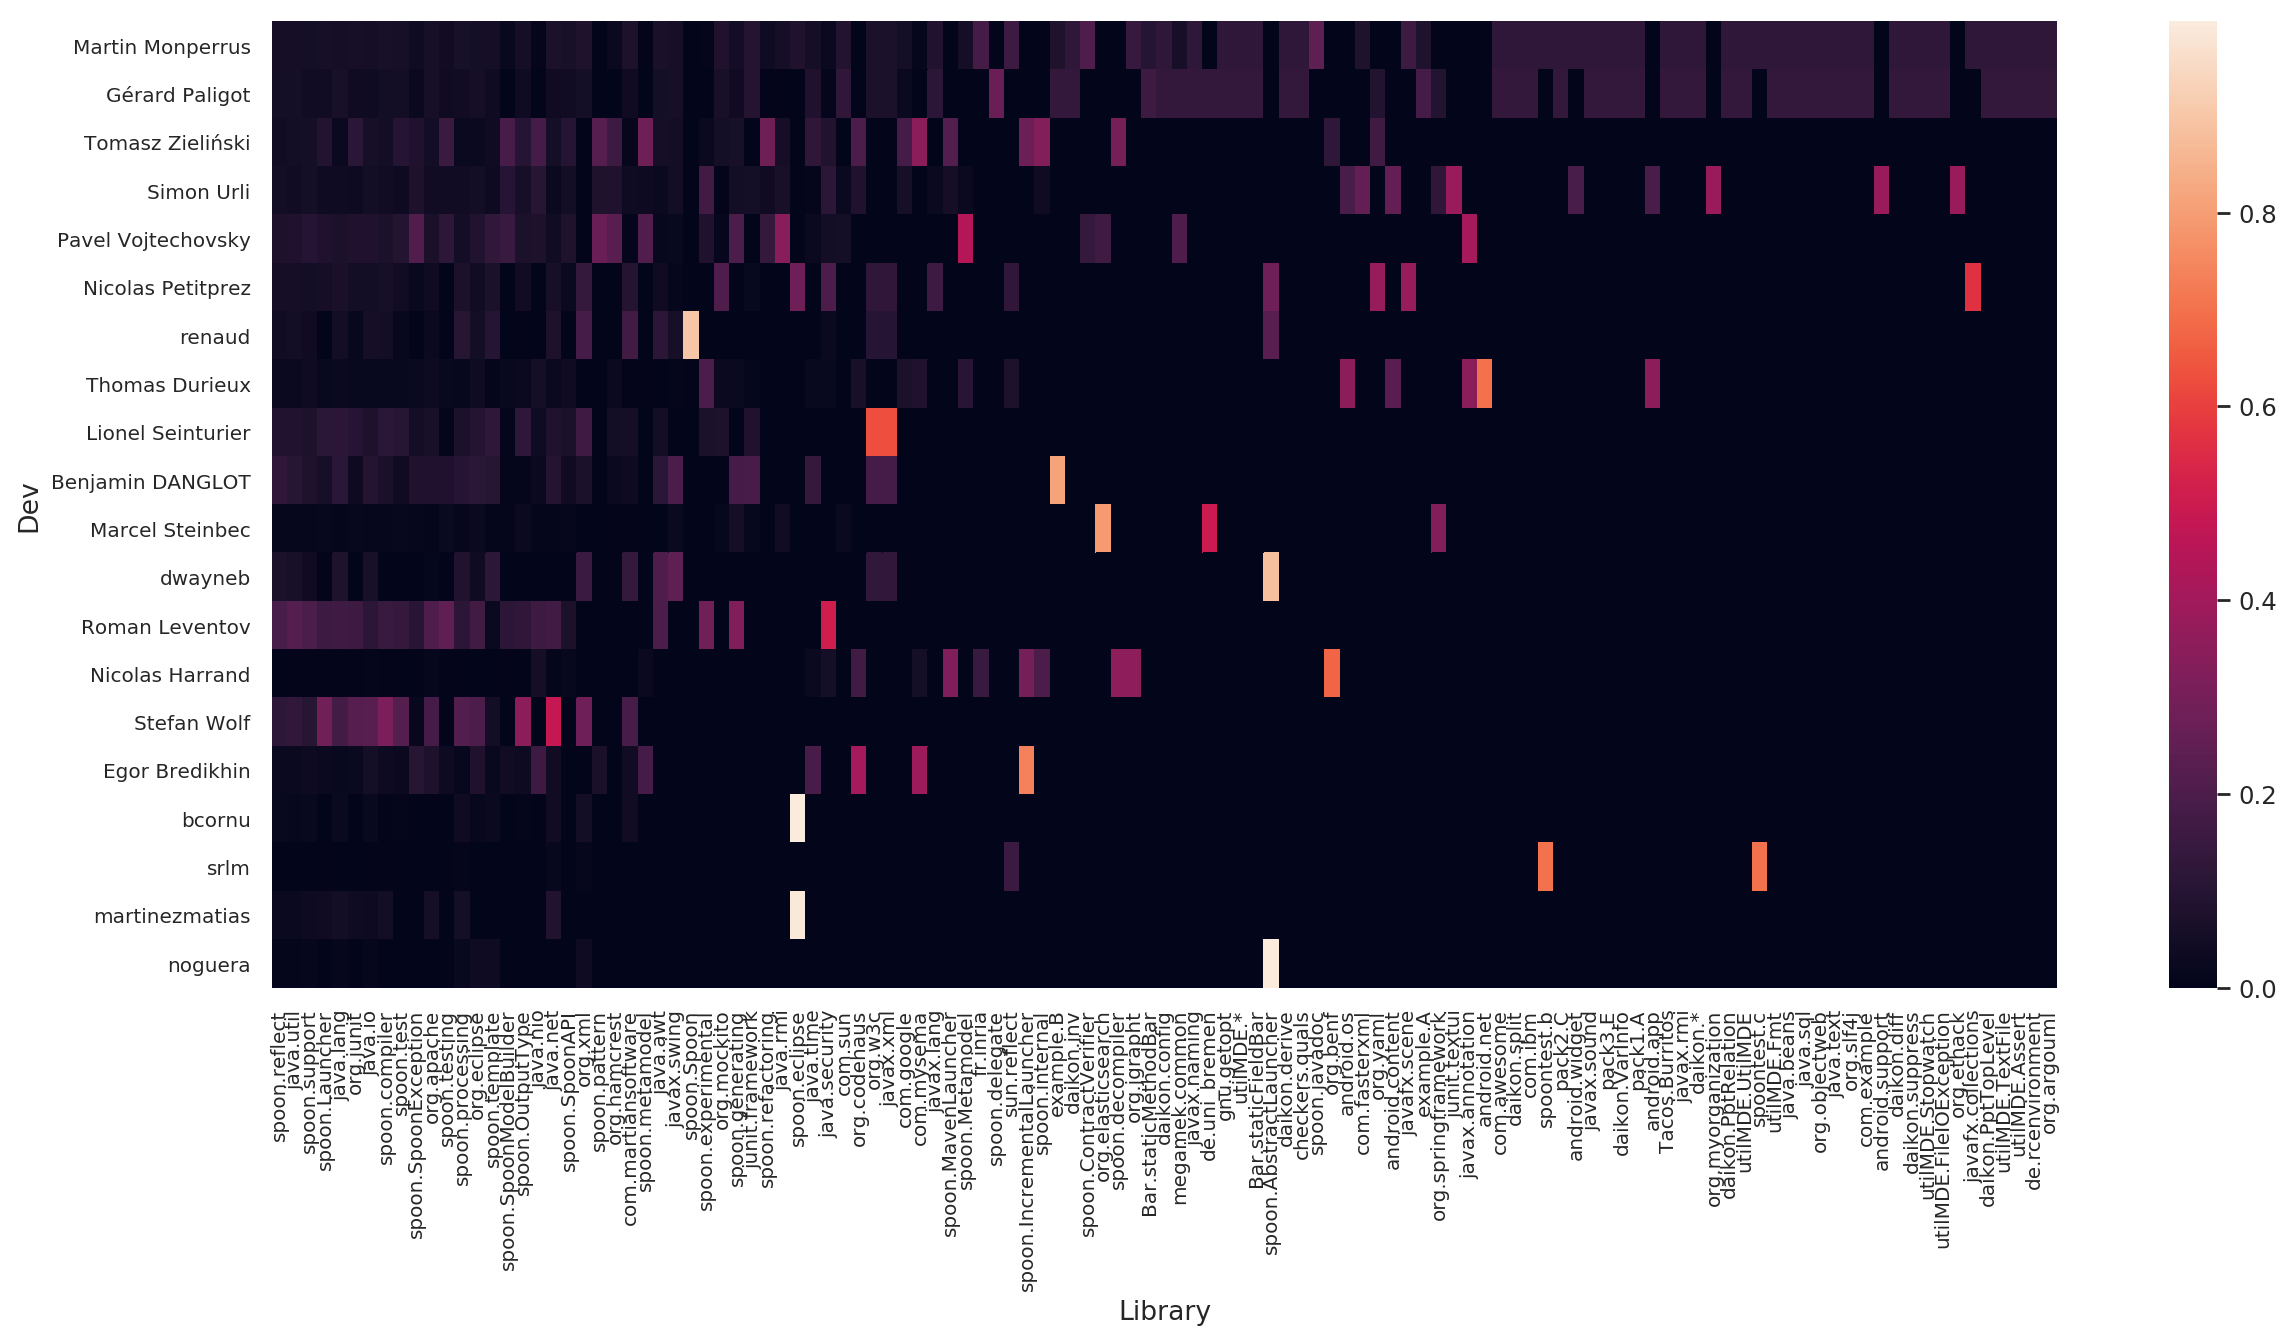

In [46]:
top_agreg_normalized_2 = top_top.div(agreg_sorted.sum(axis=0), axis = 1)
top_agreg_normalized_2 = top_agreg_normalized_2.div(np.sqrt(top_agreg_normalized_2.pow(2).sum(axis=1)), axis=0)
plot_matrix(top_agreg_normalized_2, '', xlabel='Library', ylabel='Dev')
plt.show()

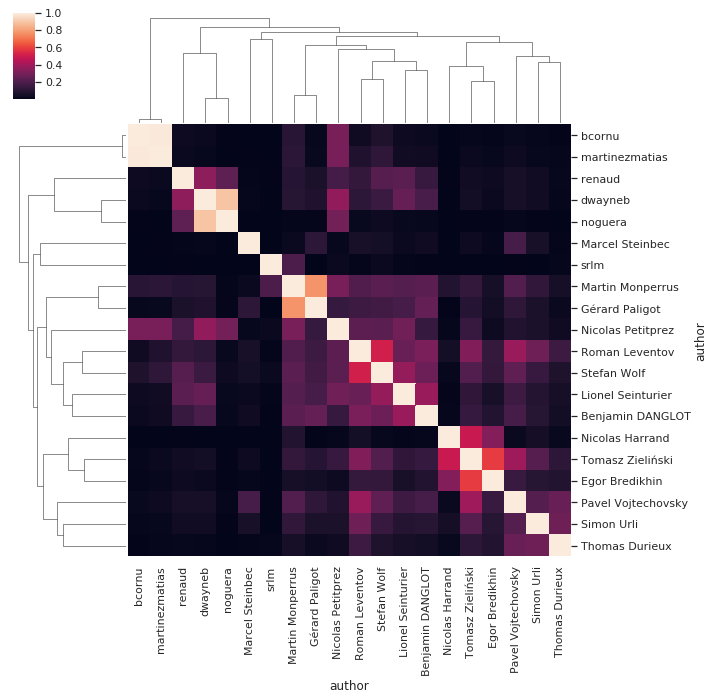

In [47]:
agreg_product_2 = pd.DataFrame(np.matrix(top_agreg_normalized_2) * np.transpose(np.matrix(top_agreg_normalized_2)))
agreg_product_2.index = top_agreg_normalized_2.index
agreg_product_2.columns = top_agreg_normalized_2.index

sns.clustermap(agreg_product_2)
save_fig('similarity_clustermap')
plt.plot();

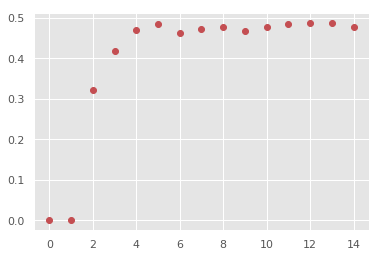

In [273]:
from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.visualization import plot_reorganized_matrix

principalDf = pd.DataFrame(data = principalComponents[:,:3], index = agreg_normalized.index
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

max_n = 15
modularities = [0]*max_n
for n in range(1,max_n):
    model = CoclustMod(n_clusters = n, n_init = 10)
    model.fit(np.matrix(top_agreg_normalized_2))
    modularities[n] = model.modularity

plt.plot(range(max_n), modularities, 'ro')
plt.show()

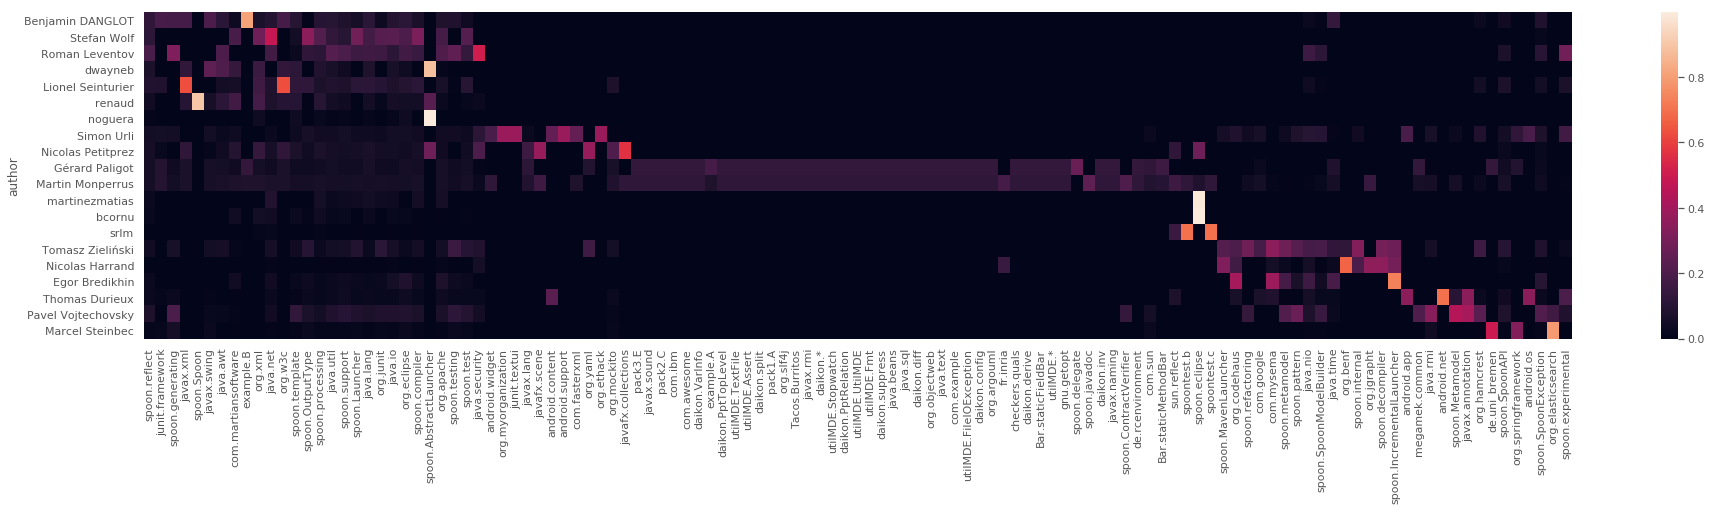

In [331]:
n_clusters = 7

model = CoclustMod(n_clusters = n_clusters, n_init = 1000, random_state=101)
model.fit(np.matrix(top_agreg_normalized_2))
fit_data = top_agreg_normalized_2.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

plt.figure(figsize=(32,6))
sns.heatmap(fit_data)
plt.show()

In [332]:
big_summary_matrix_coclust = np.zeros(fit_data.shape)
for i in range(n_clusters):
    for j in range(n_clusters):
        data = top_agreg_normalized_2.iloc[np.array(model.row_labels_) == i, np.array(model.column_labels_) == j]
        n = sum(np.array(model.row_labels_) == i) * sum(np.array(model.column_labels_) == j)
        m = data.sum().sum() / n
        for x in np.array(range(len(model.row_labels_)))[np.sort(model.row_labels_) == i]:
            for y in np.array(range(len(model.column_labels_)))[np.sort(model.column_labels_) == j]:
                big_summary_matrix_coclust[x,y] = m
summary_df_coclust = pd.DataFrame(big_summary_matrix_coclust, index=fit_data.index, columns=fit_data.columns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


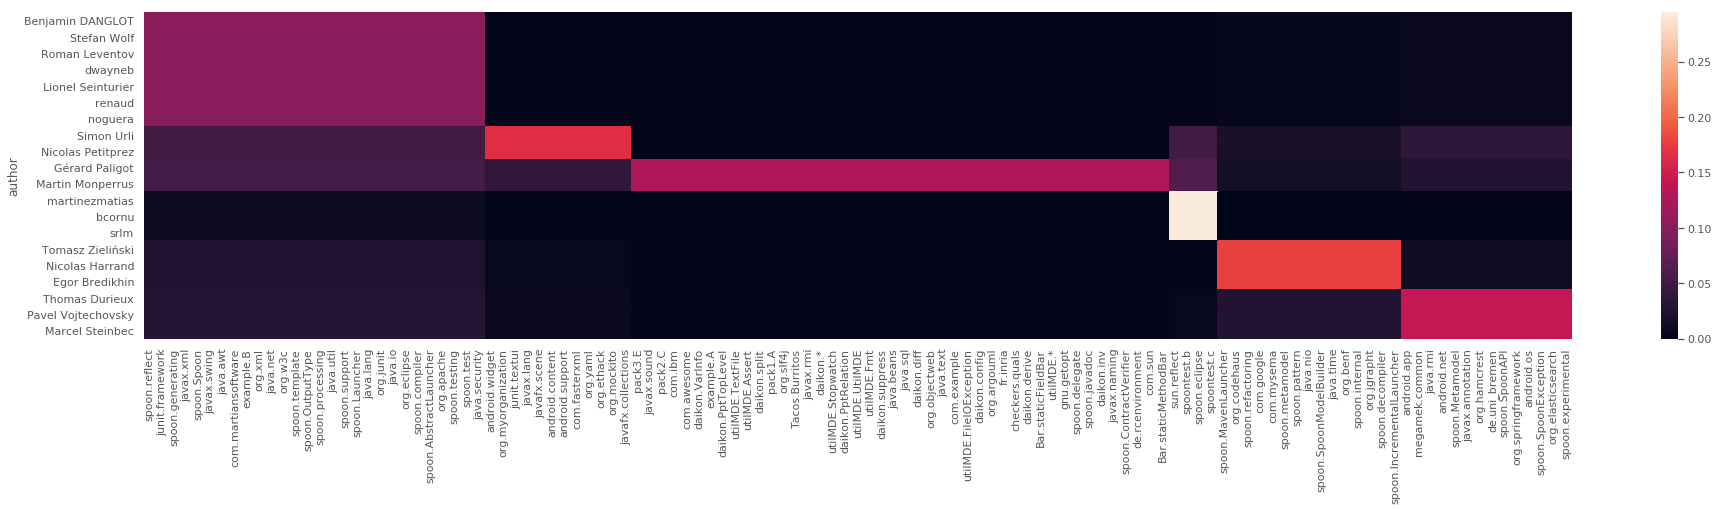

In [333]:
plt.figure(figsize=(32,6))
sns.heatmap(summary_df_coclust)
plt.show()

### t-SNE

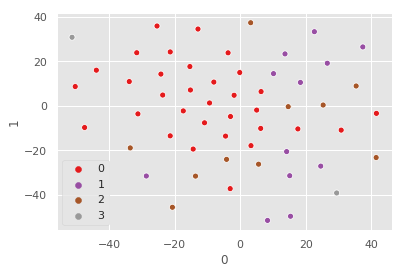

In [50]:
from sklearn.manifold import TSNE

top_agreg_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(agreg_normalized))
top_agreg_embedded.index = agreg_normalized.index

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=100).fit(agreg_normalized)

y_kmeans = kmeans.predict(agreg_normalized)

sns.scatterplot(top_agreg_embedded.iloc[:,0],top_agreg_embedded.iloc[:,1], hue=y_kmeans, palette="Set1")

### Oublie exponetielle

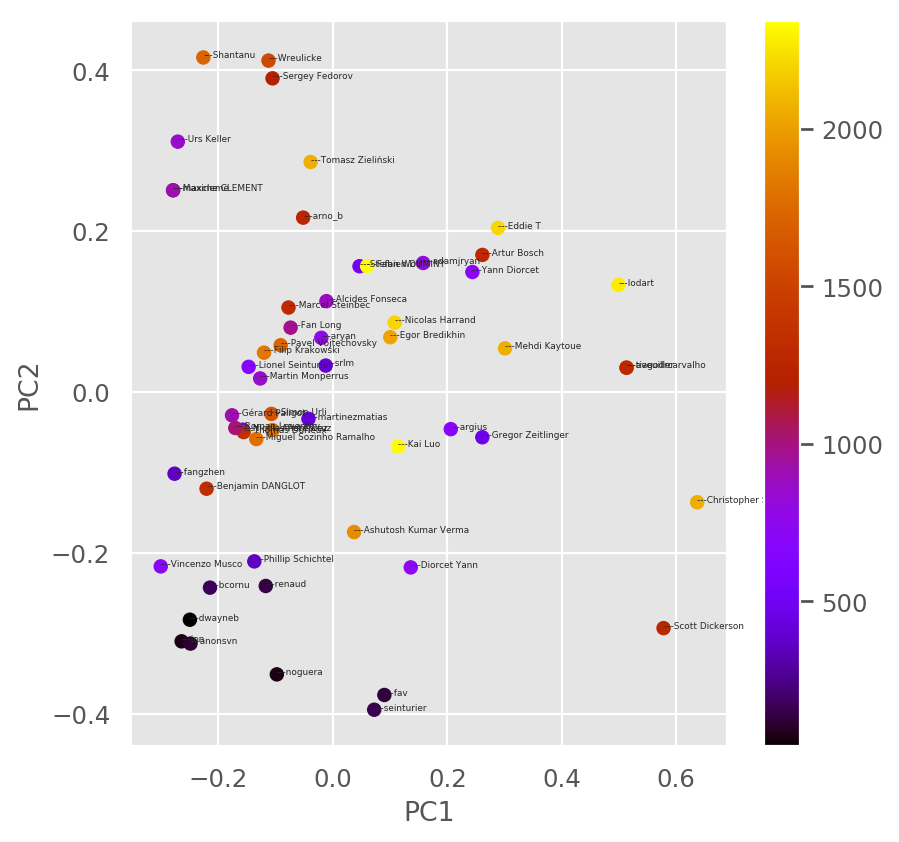

In [51]:
agreg_sorted_lib_extinction = agreg_sorted.mul(libraries_info.loc[agreg_sorted.columns, 'coef'])
agreg_sorted_lib_extinction_L2  = agreg_sorted_lib_extinction.div(np.sqrt(agreg_sorted_lib_extinction.pow(2).sum(axis=1)), axis=0)

pca = PCA(n_components=2).fit_transform(agreg_sorted_lib_extinction_L2)

principalDf = pd.DataFrame(data = pca, index = agreg_normalized.index
             , columns = ['principal component 1', 'principal component 2'])

quick_pca_plot(principalDf, 0, 1, labels=True, c=avg_contrib.loc[principalDf.index, 'index'].loc[:,'mean'])
plt.show()

### CoClust

In [245]:
from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.visualization import plot_reorganized_matrix

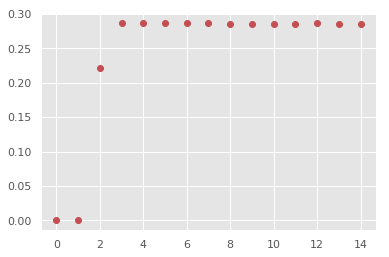

In [321]:
max_n = 15
modularities = [0]*max_n
for n in tqdm(range(1,15)):
    model = CoclustMod(n_clusters = n, n_init = 100)
    model.fit(np.matrix(top_agreg>0))
    modularities[n] = model.modularity

plt.plot(range(max_n), modularities, 'ro')
plt.show()

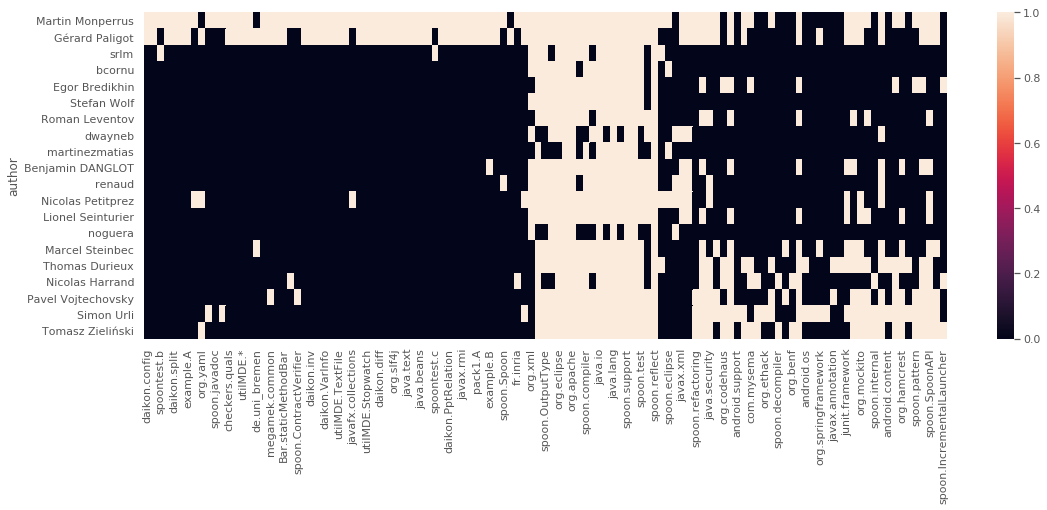

In [318]:
n_clusters = 3
model = CoclustMod(n_clusters = n_clusters, n_init = 100, random_state=400)
model.fit(np.matrix(top_agreg>0))
fit_data = top_agreg.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

plt.figure(figsize=(18,6))
sns.heatmap(fit_data>0)
save_fig('coclust_L2')
plt.show()

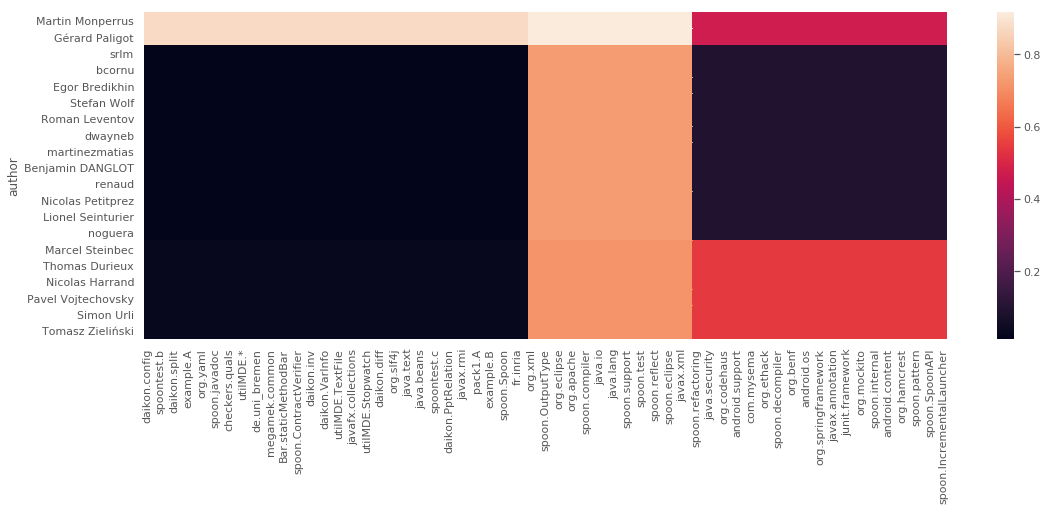

In [317]:
big_summary_matrix_coclust = np.zeros(fit_data.shape)
mat = top_agreg > 0
for i in range(n_clusters):
    res = []
    for j in range(n_clusters):
        data = mat.iloc[np.array(model.row_labels_) == i, np.array(model.column_labels_) == j]
        n = sum(np.array(model.row_labels_) == i) * sum(np.array(model.column_labels_) == j)
        m = data.sum().sum() / n
        for x in np.array(range(len(model.row_labels_)))[np.sort(model.row_labels_) == i]:
            for y in np.array(range(len(model.column_labels_)))[np.sort(model.column_labels_) == j]:
                big_summary_matrix_coclust[x,y] = m
plt.figure(figsize=(18,6))
summary_df_coclust = pd.DataFrame(big_summary_matrix_coclust, index=fit_data.index, columns=fit_data.columns)
sns.heatmap(summary_df_coclust)
save_fig('coclust_L2_summary')
plt.show()

# DEV / PACKAGE

In [53]:
from functools import reduce
#mapping, mapping_elemnts, mapping_size = define_mapping(libraries_set, 2)
packages_set = list(reduce(lambda x,y: x|y,[ 
    set([ file['package'] for file in commit['files_info'].values()])
    for commit in commit_info.values()
]))
packages_set.remove('')
packages_set.remove('app')
package_mapping, package_mapping_elemnts, package_mapping_size = define_mapping(packages_set, 3)

In [54]:
data = []
for sha, commit in list(commit_info.items()):
    packages = set()
    c = z_k(package_mapping_size)
    for file, file_info in commit['files_info'].items():
        file_packages = set([package_mapping(file_info['package'])])
        packages = packages | file_packages
        c = v_sum(c, z_k(package_mapping_size, *file_packages))
    if len(libraries) > 0:
        data.append( [sha, commit['author']['name']] + list(c))
        #data.append( [sha, commit['author']['name']] + list(z_k(mapping_size, *libraries)))

df_packages = pd.DataFrame(data=data, columns=['sha', 'author', *package_mapping_elemnts])

In [55]:
agreg_packages = df_packages.groupby('author').sum()
agreg_packages = group_duplicate_entry(agreg_packages, *duplicate_entries)
agreg_packages = agreg_packages.loc[agreg_packages.sum(axis=1) > 1]
agreg_packages = agreg_packages.loc[:,agreg_packages.sum() > 3]

agreg_packages_sorted = agreg_packages.loc[agreg_packages.sum(axis=1).sort_values(ascending=False).index]
agreg_packages_sorted = agreg_packages_sorted.loc[:,agreg_packages_sorted.sum(axis=0).sort_values(ascending=False).index]
plot_matrix(agreg_packages_sorted, 'Number of contributions (log scale)', xlabel='Package (depth=3)', ylabel='Developer', log_scale=True)

ValueError: too many values to unpack (expected 2)

In [ ]:
df_packages_commits = df_packages.iloc[:,2:]

fig = plt.figure(figsize=(4, 25), dpi=160, facecolor='w', edgecolor='k')
plt.imshow(np.log10(df_packages_commits.add(0)))
plt.ylabel('Commit')
plt.xlabel('Package')
plt.show()